Columns detected after initial CSV load:
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR', 'FREQUENCY', 'SCALE', 'PRECISION', 'DECIMALS_DISPLAYED', 'FUNCTIONAL_CAT', 'INT_ACC_ITEM', 'NA_STO', 'GFS_STO', 'COICOP_1999', 'TRADE_FLOW', 'COMMODITY', 'SOC_CONCEPTS', 'SECTOR', 'ACCOUNTING_ENTRY', 'INDEX_TYPE', 'PRICES', 'VALUATION', 'STATISTICAL_MEASURES', 'EXRATE', 'TRANSFORMATION', 'UNIT', 'REPORTING_PERIOD_TYPE', 'DERIVATION_TYPE', 'OVERLAP', 'LATEST_ACTUAL_ANNUAL_DATA', 'DOI', 'FULL_DESCRIPTION', 'AUTHOR', 'PUBLISHER', 'DEPARTMENT', 'CONTACT_POINT', 'TOPIC', 'TOPIC_DATASET', 'KEYWORDS', 'KEYWORDS_DATASET', 'LANGUAGE', 'PUBLICATION_DATE', 'UPDATE_DATE', 'METHODOLOGY', 'METHODOLOGY_NOTES', 'ACCESS_SHARING_LEVEL', 'ACCESS_SHARING_NOTES', 'SECURITY_CLASSIFICATION', 'SOURCE', 'SHORT_SOURCE_CITATION', 'FULL_SOURCE_CITATION', 'LICENSE', 'SUGGESTED_CITATION', 'KEY_INDICATOR', 'SERIES_NAME', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '19

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

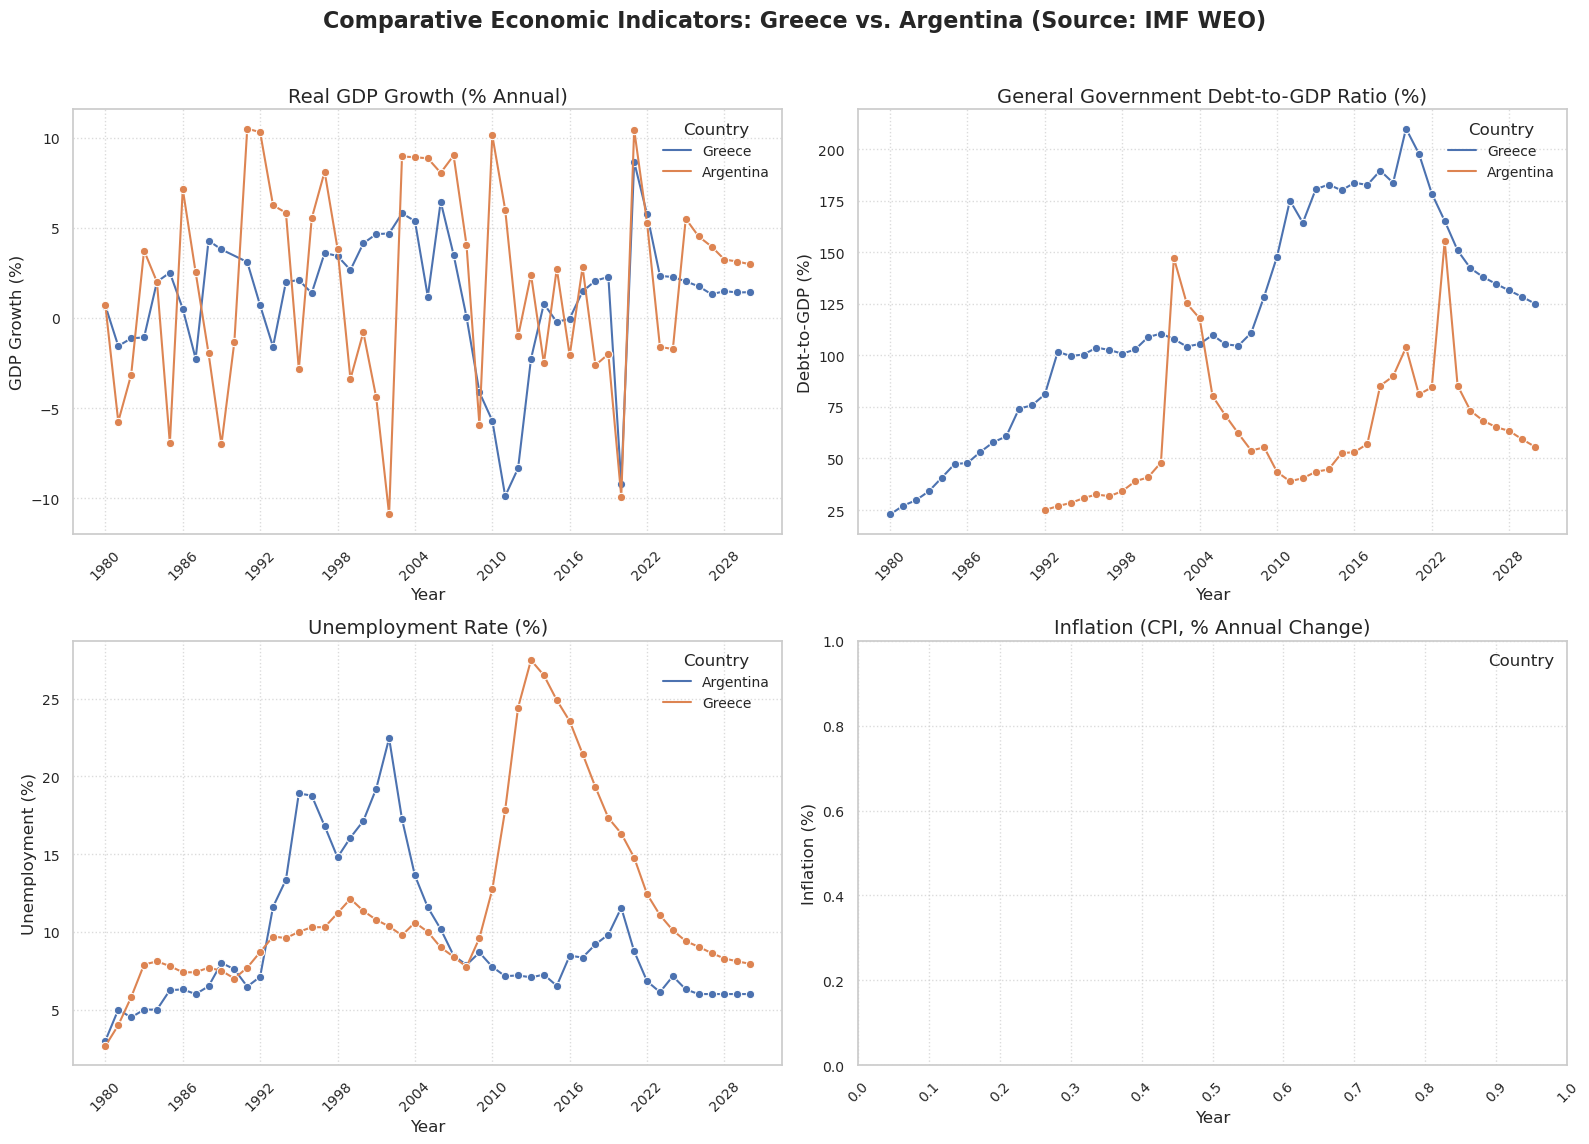

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

IMF_WEO_FILE = "debt to gdp greece &argentina_2025-06-06T13_54_16.982603818Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv"

SKIP_ROWS_IMF_WEO = 0

def load_and_process_imf_weo(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)

        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())

        if 'COUNTRY' in df_raw.columns:
            df_raw.rename(columns={'COUNTRY': 'Country'}, inplace=True)
        elif 'Country' not in df_raw.columns:
            print("Error: 'COUNTRY' column not found or not correctly identified. Please verify the exact country column name in your CSV.")
            return pd.DataFrame()

        if 'INDICATOR' not in df_raw.columns:
            if 'Subject Descriptor' in df_raw.columns:
                df_raw.rename(columns={'Subject Descriptor': 'INDICATOR'}, inplace=True)
                print("Renamed 'Subject Descriptor' to 'INDICATOR'.")
            elif 'Series Name' in df_raw.columns:
                df_raw.rename(columns={'Series Name': 'INDICATOR'}, inplace=True)
                print("Renamed 'Series Name' to 'INDICATOR'.")
            else:
                print("Error: 'INDICATOR' column (or common alternatives like 'Subject Descriptor', 'Series Name') not found. Please check the exact column name for indicators in your CSV.")
                return pd.DataFrame()


        indicator_names = {
            'Debt_to_GDP': 'Gross debt, General government, Percent of GDP',
            'GDP_Growth': 'Gross domestic product (GDP), Constant prices, Percent change',
            'Unemployment': 'Unemployment rate',
            'Inflation_CPI': 'All items, Consumer price index (CPI), Period average, percent change'
        }

        df_filtered = df_raw[
            (df_raw['Country'].isin(['Argentina', 'Greece'])) &
            (df_raw['INDICATOR'].isin(indicator_names.values()))
        ].copy()

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= 1980 and int(col) <= 2030]
        df_selected = df_filtered[['Country', 'INDICATOR'] + year_cols]

        df_long = df_selected.melt(
            id_vars=['Country', 'INDICATOR'],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

        df_long.dropna(subset=['Value', 'Year'], inplace=True)

        reverse_indicator_map = {v: k for k, v in indicator_names.items()}
        df_long['Indicator_Type'] = df_long['INDICATOR'].map(reverse_indicator_map)

        print(f"Successfully processed {file_path}.")
        return df_long

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_imf_weo = load_and_process_imf_weo(IMF_WEO_FILE, SKIP_ROWS_IMF_WEO)

if df_imf_weo.empty:
    print("No data loaded or processed from IMF WEO file. Cannot generate plots.")
else:
    df_gdp_growth = df_imf_weo[df_imf_weo['Indicator_Type'] == 'GDP_Growth']
    df_debt_to_gdp = df_imf_weo[df_imf_weo['Indicator_Type'] == 'Debt_to_GDP']
    df_unemployment = df_imf_weo[df_imf_weo['Indicator_Type'] == 'Unemployment']
    df_inflation = df_imf_weo[df_imf_weo['Indicator_Type'] == 'Inflation_CPI']

    def plot_comparative_indicator(ax, df, title, ylabel):
        sns.lineplot(x='Year', y='Value', hue='Country', data=df, ax=ax, marker='o', linestyle='-', errorbar=None)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.legend(title='Country', fontsize=10)
        ax.grid(True, linestyle=':', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=10))
        plt.tight_layout()

    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

    fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
    fig1.suptitle('Comparative Economic Indicators: Greece vs. Argentina (Source: IMF WEO)', fontsize=16, fontweight='bold')

    plot_comparative_indicator(axes1[0, 0], df_gdp_growth,
                               'Real GDP Growth (% Annual)', 'GDP Growth (%)')

    plot_comparative_indicator(axes1[0, 1], df_debt_to_gdp,
                               'General Government Debt-to-GDP Ratio (%)', 'Debt-to-GDP (%)')

    plot_comparative_indicator(axes1[1, 0], df_unemployment,
                               'Unemployment Rate (%)', 'Unemployment (%)')

    plot_comparative_indicator(axes1[1, 1], df_inflation,
                               'Inflation (CPI, % Annual Change)', 'Inflation (%)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()



Successfully processed REER data from API_PX.Real-effective-ex-rate-greece.REER_DS2_en_excel_v2_2723.csv.


/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


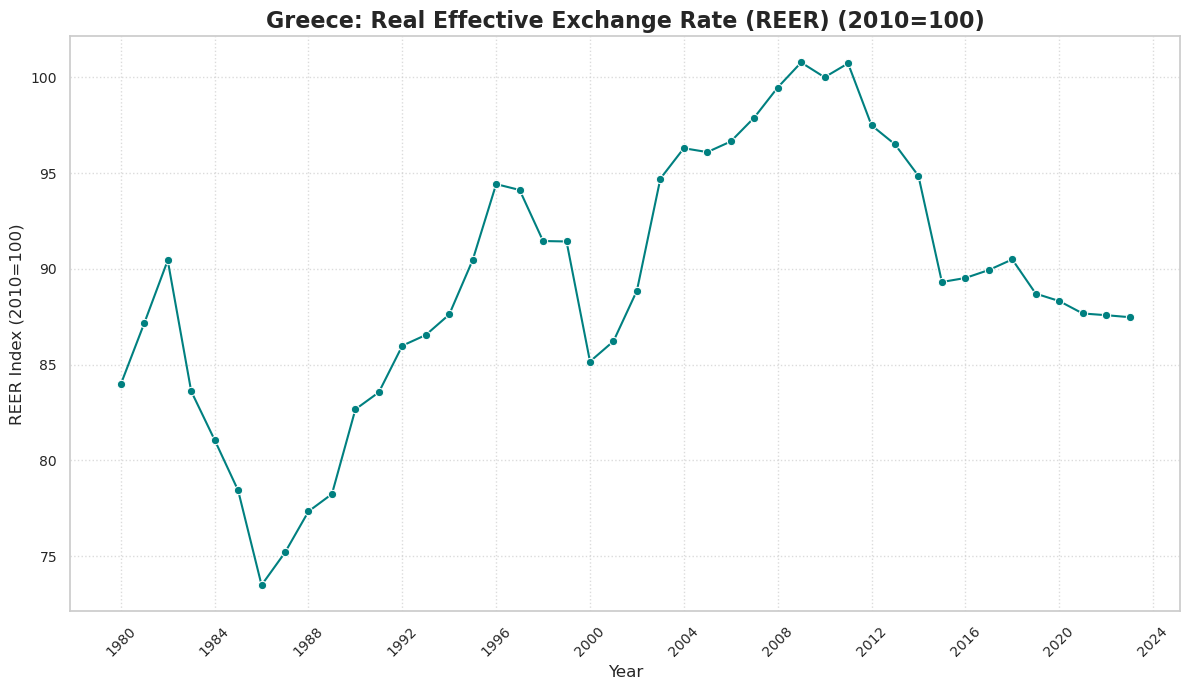

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

GREECE_REER_FILE = "API_PX.Real-effective-ex-rate-greece.REER_DS2_en_excel_v2_2723.csv"


SKIP_ROWS_REER = 3


def load_and_process_reer_data(file_path, skip_rows):
    """
    Loads the REER CSV, cleans it, and reshapes it for plotting.
    Filters for Greece and the REER indicator.
    """
    try:
        
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)
        
        df_raw.rename(columns={
            'Country Name': 'Country',
            'Indicator Name': 'Indicator',
            'Indicator Code': 'IndicatorCode'
        }, inplace=True)

        reer_indicator_code = 'PX.REX.REER'
        df_filtered = df_raw[
            (df_raw['Country'] == 'Greece') &
            (df_raw['IndicatorCode'] == reer_indicator_code)
        ].copy()

        if df_filtered.empty:
            print(f"No REER data found for Greece in {file_path}. Please check Country Name, Indicator Code, and skiprows.")
            return pd.DataFrame()
            
        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= 1960]
        df_selected = df_filtered[['Country', 'Indicator'] + year_cols]

        df_long = df_selected.melt(
            id_vars=['Country', 'Indicator'],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

        df_long.dropna(subset=['Value', 'Year'], inplace=True)

        print(f"Successfully processed REER data from {file_path}.")
        return df_long

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_greece_reer = load_and_process_reer_data(GREECE_REER_FILE, SKIP_ROWS_REER)

if df_greece_reer.empty:
    print("Cannot generate plot as no REER data was loaded for Greece.")
else:
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(x='Year', y='Value', data=df_greece_reer, ax=ax, marker='o', linestyle='-', color='teal', errorbar=None)

    ax.set_title('Greece: Real Effective Exchange Rate (REER) (2010=100)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('REER Index (2010=100)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15)) # Adjust number of x-axis ticks for clarity
    plt.tight_layout()
    plt.show()


In [1]:
!pip install xlrd


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels



--- Processing CPI File: CPI data for Greece.csv ---
Columns detected after initial CSV load:
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDEX_TYPE', 'COICOP_1999', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'SCALE', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
First 10 rows of raw data (including potential metadata):
              DATASET                 SERIES_CODE OBS_MEASURE COUNTRY                  INDEX_TYPE COICOP_1999                               TYPE_OF_TRANSFORMATION FREQUENCY  SCALE      2000      2001      2002     2003      2004      2005      2006      2007      2008      2009      2010      2011      2012      2013      2014      2015      2016      2017      2018      2019      2020      2021     2022      2023     2024
0  IMF.STA:CPI(4.0.0)  GRC.CPI._T.YOY_PCH_PA_PT.A   OBS_VALUE  Greece  Consumer price inde

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


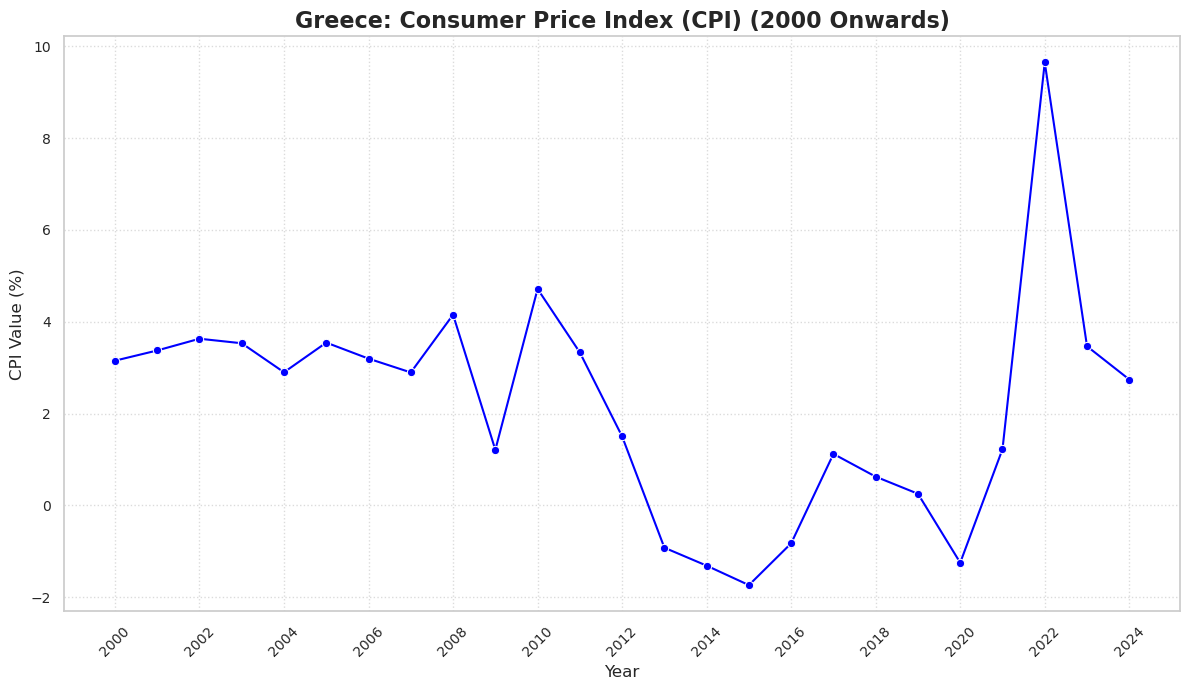

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

GREECE_CPI_FILE = "CPI data for Greece.csv"

SKIP_ROWS_CPI = 0

def load_and_process_cpi_data(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)

        print(f"\n--- Processing CPI File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 10 rows of raw data (including potential metadata):")
        print(df_raw.head(10).to_string())

        df_raw.columns = df_raw.columns.str.strip()

        if len(df_raw.columns) > 5:
            df_raw.rename(columns={
                df_raw.columns[3]: 'Country_Identifier',
                df_raw.columns[5]: 'Indicator_Transformation'
            }, inplace=True)
        else:
            print("Error: Expected columns at index 3 or 5 not found. CSV structure might be different.")
            return pd.DataFrame()

        df_greece = df_raw[df_raw['Country_Identifier'].astype(str).str.strip() == 'Greece'].copy()

        if df_greece.empty:
            print("No data found for 'Greece' in 'Country_Identifier' column.")
            print("Available values in 'Country_Identifier':", df_raw['Country_Identifier'].unique().tolist())
            print("Please verify the exact country name in the CSV.")
            return pd.DataFrame()

        target_cpi_transformation = 'All Items' 

        df_greece_cpi_filtered = df_greece[
            df_greece['Indicator_Transformation'].astype(str).str.strip().str.contains(target_cpi_transformation, na=False, regex=False)
        ].copy()

        if df_greece_cpi_filtered.empty:
            print(f"No data found for CPI transformation '{target_cpi_transformation}' for Greece.")
            print("Available transformations for Greece:", df_greece['Indicator_Transformation'].unique().tolist())
            print("Please verify the exact transformation string in the CSV.")
            return pd.DataFrame()

        year_cols = [col for col in df_greece_cpi_filtered.columns if str(col).isdigit() and int(col) >= 2000]
        if not year_cols:
            print("Error: No year columns found from 2000 onwards. Please check CSV structure.")
            return pd.DataFrame()

        df_final = df_greece_cpi_filtered.melt(
            id_vars=['Country_Identifier', 'Indicator_Transformation'],
            value_vars=year_cols,
            var_name='Year_Plot',
            value_name='CPI_Value'
        )

        df_final['Year_Plot'] = pd.to_numeric(df_final['Year_Plot'], errors='coerce').astype(int)
        df_final['CPI_Value'] = pd.to_numeric(df_final['CPI_Value'], errors='coerce')

        df_final.dropna(subset=['CPI_Value', 'Year_Plot'], inplace=True)

        print(f"Successfully processed CPI data from {file_path} for Greece from 2000 onwards.")
        return df_final

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_greece_cpi = load_and_process_cpi_data(GREECE_CPI_FILE, SKIP_ROWS_CPI)

if df_greece_cpi.empty:
    print("Cannot generate plot as no CPI data was loaded for Greece.")
else:
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(x='Year_Plot', y='CPI_Value', data=df_greece_cpi, ax=ax, marker='o', linestyle='-', color='blue', errorbar=None)

    ax.set_title('Greece: Consumer Price Index (CPI) (2000 Onwards)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('CPI Value (%)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
    plt.tight_layout()
    plt.show()



--- Processing Argentina Debt to GDP File: imf-dm-argentina-gross-debt-20250607.csv ---
Columns detected after initial CSV load:
['General government gross debt (Percent of GDP)', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030']
First 5 rows of raw data (including potential metadata):
  General government gross debt (Percent of GDP)     1980     1981     1982     1983     1984     1985     1986     1987     1988     1989     1990     1991  1992  1993  1994  1995  1996  1997  1998  1999  2000  2001   2002   2003   2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019   2020  2021  2022   2023 

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


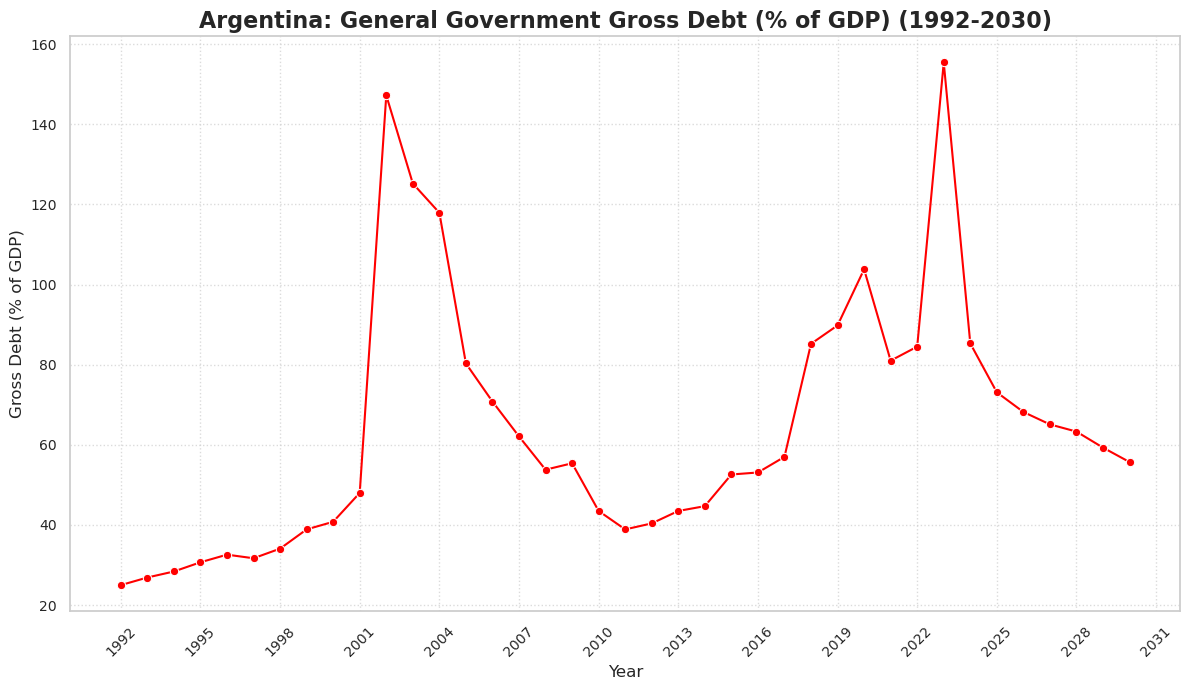

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_DEBT_GDP_FILE = "imf-dm-argentina-gross-debt-20250607.csv"

SKIP_ROWS_DEBT_GDP = 0

def load_and_process_argentina_debt_gdp(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)

        print(f"\n--- Processing Argentina Debt to GDP File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 5 rows of raw data (including potential metadata):")
        print(df_raw.head().to_string())

        indicator_desc_col = df_raw.columns[0]
        
        country_col_name = None
        for col_idx, col_name in enumerate(df_raw.columns):
            if df_raw[col_name].astype(str).str.contains('Argentina', na=False).any():
                country_col_name = col_name
                break
        
        if country_col_name is None:
            print("Error: Could not find the column containing 'Argentina'. Please check CSV headers and content.")
            return pd.DataFrame()

        df_argentina_data_row = df_raw[df_raw[country_col_name].astype(str).str.contains('Argentina', na=False)].copy()
        
        if df_argentina_data_row.empty:
            print("No data row found for 'Argentina'. Please check the exact country name or row structure.")
            return pd.DataFrame()

        year_cols = [col for col in df_argentina_data_row.columns if str(col).isdigit() and int(col) >= 1992 and int(col) <= 2030]
        if not year_cols:
            print("Error: No year columns found from 1992 to 2030. Please check CSV structure.")
            return pd.DataFrame()

        df_final = df_argentina_data_row.melt(
            id_vars=[col for col in df_argentina_data_row.columns if col not in year_cols],
            value_vars=year_cols,
            var_name='Year_Plot',
            value_name='Debt_to_GDP_Value'
        )

        df_final['Year_Plot'] = pd.to_numeric(df_final['Year_Plot'], errors='coerce').astype(int)
        df_final['Debt_to_GDP_Value'] = pd.to_numeric(df_final['Debt_to_GDP_Value'], errors='coerce')

        df_final.dropna(subset=['Debt_to_GDP_Value', 'Year_Plot'], inplace=True)

        print(f"Successfully processed Gross Debt to GDP data from {file_path} for Argentina from 1992 to 2030.")
        return df_final

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_argentina_debt_gdp = load_and_process_argentina_debt_gdp(ARGENTINA_DEBT_GDP_FILE, SKIP_ROWS_DEBT_GDP)

if df_argentina_debt_gdp.empty:
    print("Cannot generate plot as no Gross Debt to GDP data was loaded for Argentina.")
else:
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(x='Year_Plot', y='Debt_to_GDP_Value', data=df_argentina_debt_gdp, ax=ax, marker='o', linestyle='-', color='red', errorbar=None)

    ax.set_title('Argentina: General Government Gross Debt (% of GDP) (1992-2030)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Gross Debt (% of GDP)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
    plt.tight_layout()
    plt.show()



--- Processing Argentina Net BOP File: Net BOP data for Argentina.csv ---
Columns detected after initial CSV load:
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'BOP_ACCOUNTING_ENTRY', 'INDICATOR', 'UNIT', 'FREQUENCY', 'SCALE', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
First 5 rows of raw data (including potential metadata):
               DATASET           SERIES_CODE OBS_MEASURE    COUNTRY       BOP_ACCOUNTING_ENTRY           INDICATOR       UNIT FREQUENCY     SCALE    1990    1991    1992     1993    1994      1995         1996         1997         1998         1999         2000         2001      2002     2003      2004      2005          2006          2007          2008         2009          2010        2011          2012        2013       

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


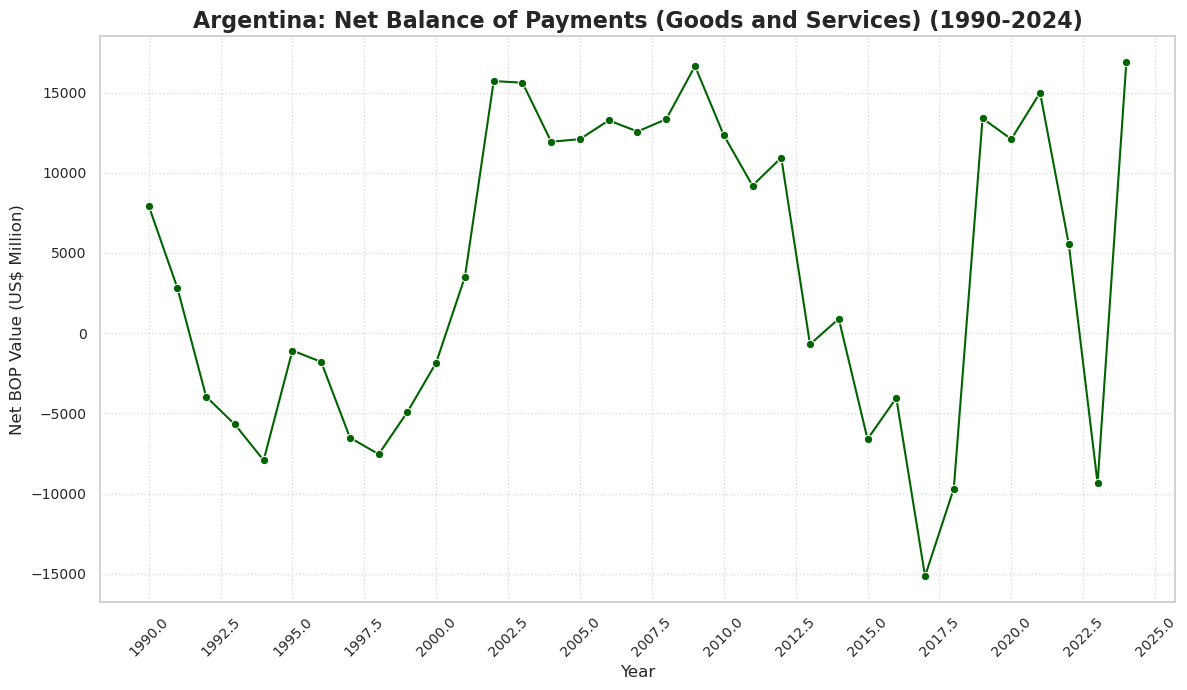

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_NET_BOP_FILE = "Net BOP data for Argentina.csv"

SKIP_ROWS_NET_BOP = 0

def load_and_process_argentina_net_bop(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)

        print(f"\n--- Processing Argentina Net BOP File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 5 rows of raw data (including potential metadata):")
        print(df_raw.head().to_string())

        df_argentina = df_raw[df_raw['COUNTRY'] == 'Argentina'].copy()

        if df_argentina.empty:
            print("No data found for 'Argentina' in 'COUNTRY' column.")
            print("Available countries:", df_raw['COUNTRY'].unique().tolist())
            print("Please verify the exact country name in the CSV.")
            return pd.DataFrame()

        if 'BOP_ACCOUNTING_ENTRY' not in df_argentina.columns or 'INDICATOR' not in df_argentina.columns:
            print("Error: 'BOP_ACCOUNTING_ENTRY' or 'INDICATOR' columns not found. Please check CSV headers.")
            return pd.DataFrame()

        target_bop_entry = 'Net (credits less debits)'
        target_indicator_type = 'Goods and services'

        df_filtered_bop = df_argentina[
            (df_argentina['BOP_ACCOUNTING_ENTRY'] == target_bop_entry) &
            (df_argentina['INDICATOR'] == target_indicator_type)
        ].copy()

        if df_filtered_bop.empty:
            print(f"No data found for '{target_bop_entry}' and '{target_indicator_type}' for Argentina.")
            print("Available BOP Accounting Entries:", df_argentina['BOP_ACCOUNTING_ENTRY'].unique().tolist())
            print("Available Indicators:", df_argentina['INDICATOR'].unique().tolist())
            print("Please verify the exact indicator strings in the CSV.")
            return pd.DataFrame()

        year_cols = [col for col in df_filtered_bop.columns if str(col).isdigit() and int(col) >= 1990 and int(col) <= 2024]
        if not year_cols:
            print("Error: No year columns found from 1990 to 2024. Please check CSV structure.")
            return pd.DataFrame()

        df_final = df_filtered_bop.melt(
            id_vars=['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'BOP_ACCOUNTING_ENTRY', 'INDICATOR'],
            value_vars=year_cols,
            var_name='Year_Plot',
            value_name='Net_BOP_Value'
        )

        df_final['Year_Plot'] = pd.to_numeric(df_final['Year_Plot'], errors='coerce').astype(int)
        df_final['Net_BOP_Value'] = pd.to_numeric(df_final['Net_BOP_Value'], errors='coerce')

        df_final.dropna(subset=['Net_BOP_Value', 'Year_Plot'], inplace=True)

        print(f"Successfully processed Net BOP data from {file_path} for Argentina from 1990 to 2024.")
        return df_final

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_argentina_net_bop = load_and_process_argentina_net_bop(ARGENTINA_NET_BOP_FILE, SKIP_ROWS_NET_BOP)

if df_argentina_net_bop.empty:
    print("Cannot generate plot as no Net BOP data was loaded for Argentina.")
else:
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

    fig, ax = plt.subplots(figsize=(12, 7))
    sns.lineplot(x='Year_Plot', y='Net_BOP_Value', data=df_argentina_net_bop, ax=ax, marker='o', linestyle='-', color='darkgreen', errorbar=None)

    ax.set_title('Argentina: Net Balance of Payments (Goods and Services) (1990-2024)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Net BOP Value (US$ Million)', fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=15))
    plt.tight_layout()
    plt.show()


# Regression model Debt to GDP ratio vs GDP growth


In [6]:
!pip install xlrd

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels



--- Processing IMF WEO File: weo_greece_argentina_data.csv ---
Columns detected after initial CSV load:
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR', 'FREQUENCY', 'SCALE', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']
First 5 rows of raw data (including potential metadata):
              DATASET        SERIES_CODE OBS_MEASURE    COUNTRY                                                      INDICATOR FREQUENCY  SCALE    1992     1993    1994     1995     1996     1997     1998     1999     2000     2001     2002     2003     2004     2005     2006     2007     2008     2009     2010     2011     2012     2013     2014     2015     2016     2017     2018     2019     2020     2021     2022     2023     2024     2025
0  IMF.RES:WEO(6.0.0)  ARG.GGX

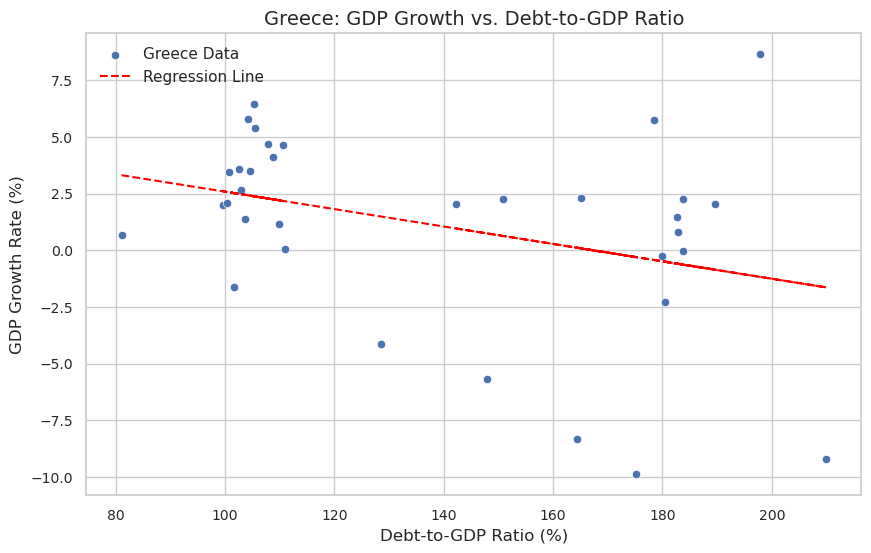


Argentina Regression Results (GDP Growth vs. Debt-to-GDP):
                            OLS Regression Results                            
Dep. Variable:        GDP_Growth_Rate   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.809
Date:                Wed, 16 Jul 2025   Prob (F-statistic):              0.188
Time:                        10:08:39   Log-Likelihood:                -107.06
No. Observations:                  34   AIC:                             218.1
Df Residuals:                      32   BIC:                             221.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

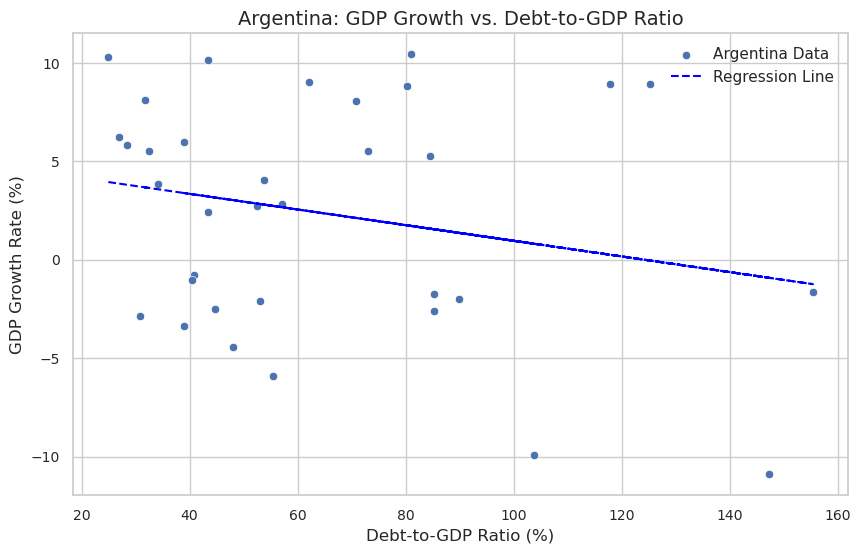


--- Interpretation of Regression Results ---
Look at the 'Coef' for 'Debt_to_GDP_Ratio': A negative coefficient suggests that as debt-to-GDP increases, GDP growth tends to decrease.
R-squared: Indicates how much of the variation in GDP growth is explained by Debt-to-GDP.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import statsmodels.api as sm

IMF_WEO_FILE = "weo_greece_argentina_data.csv"

SKIP_ROWS_IMF_WEO = 0

def load_and_process_imf_weo(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)

        print(f"\n--- Processing IMF WEO File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 5 rows of raw data (including potential metadata):")
        print(df_raw.head().to_string())

        df_raw.columns = df_raw.columns.str.strip()

        if 'COUNTRY' in df_raw.columns:
            df_raw.rename(columns={'COUNTRY': 'Country'}, inplace=True)
        else:
            print("Error: 'COUNTRY' column not found. Please verify the exact country column name in your CSV.")
            return pd.DataFrame()

        if 'INDICATOR' in df_raw.columns:
            df_raw.rename(columns={'INDICATOR': 'Indicator_Description'}, inplace=True)
        else:
            print("Error: 'INDICATOR' column not found. Please verify the exact indicator column name in your CSV.")
            return pd.DataFrame()

        df_raw['Country'] = df_raw['Country'].astype(str).str.strip()
        df_raw['Indicator_Description'] = df_raw['Indicator_Description'].astype(str).str.strip()

        print("\nUnique values in the 'Country' column after renaming and stripping whitespace:")
        print(df_raw['Country'].unique().tolist())
        print("\nUnique values in the 'Indicator_Description' column after cleaning:")
        print(df_raw['Indicator_Description'].unique().tolist())

        indicator_names = {
            'Debt_to_GDP': 'Gross debt, General government, Percent of GDP',
            'GDP_Growth': 'Gross domestic product (GDP), Constant prices, Percent change',
            'Unemployment': 'Unemployment rate',
            'Inflation_CPI': 'Consumer price index, Percent change'
        }

        df_filtered = df_raw[
            (df_raw['Country'].isin(['Argentina', 'Greece'])) &
            (df_raw['Indicator_Description'].isin(indicator_names.values()))
        ].copy()

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= 1992 and int(col) <= 2025]
        if not year_cols:
            print("Error: No year columns found from 1992 to 2025. Please check CSV structure.")
            return pd.DataFrame()

        df_selected = df_filtered[['Country', 'Indicator_Description'] + year_cols]

        df_long = df_selected.melt(
            id_vars=['Country', 'Indicator_Description'],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

        df_long.dropna(subset=['Value', 'Year'], inplace=True)

        reverse_indicator_map = {v: k for k, v in indicator_names.items()}
        df_long['Indicator_Type'] = df_long['Indicator_Description'].map(reverse_indicator_map)

        print(f"Successfully processed {file_path}.")
        return df_long

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_imf_weo = load_and_process_imf_weo(IMF_WEO_FILE, SKIP_ROWS_IMF_WEO)

if df_imf_weo.empty:
    print("No data loaded or processed from IMF WEO file. Cannot generate plots or perform regression.")
else:
    df_regression = df_imf_weo[
        df_imf_weo['Indicator_Type'].isin(['Debt_to_GDP', 'GDP_Growth'])
    ].pivot_table(index=['Country', 'Year'], columns='Indicator_Type', values='Value').reset_index()

    df_regression.rename(columns={
        'Debt_to_GDP': 'Debt_to_GDP_Ratio',
        'GDP_Growth': 'GDP_Growth_Rate'
    }, inplace=True)

    print("\nHead of df_regression DataFrame before final dropna:")
    print(df_regression.head().to_string())
    print("\nColumns of df_regression DataFrame:")
    print(df_regression.columns.tolist())

    df_regression.dropna(subset=['Debt_to_GDP_Ratio', 'GDP_Growth_Rate'], inplace=True)

    print("\n--- Regression Analysis: Debt-to-GDP Ratio vs. GDP Growth ---")

    df_greece_reg = df_regression[df_regression['Country'] == 'Greece'].copy()
    if not df_greece_reg.empty and len(df_greece_reg) > 1:
        X_greece = sm.add_constant(df_greece_reg['Debt_to_GDP_Ratio'])
        y_greece = df_greece_reg['GDP_Growth_Rate']
        model_greece = sm.OLS(y_greece, X_greece).fit()
        print("\nGreece Regression Results (GDP Growth vs. Debt-to-GDP):")
        print(model_greece.summary())

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Debt_to_GDP_Ratio', y='GDP_Growth_Rate', data=df_greece_reg, label='Greece Data')
        plt.plot(df_greece_reg['Debt_to_GDP_Ratio'], model_greece.predict(X_greece), color='red', linestyle='--', label='Regression Line')
        plt.title('Greece: GDP Growth vs. Debt-to-GDP Ratio')
        plt.xlabel('Debt-to-GDP Ratio (%)')
        plt.ylabel('GDP Growth Rate (%)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNot enough data for Greece to perform regression.")

    df_argentina_reg = df_regression[df_regression['Country'] == 'Argentina'].copy()
    if not df_argentina_reg.empty and len(df_argentina_reg) > 1:
        X_argentina = sm.add_constant(df_argentina_reg['Debt_to_GDP_Ratio'])
        y_argentina = df_argentina_reg['GDP_Growth_Rate']
        model_argentina = sm.OLS(y_argentina, X_argentina).fit()
        print("\nArgentina Regression Results (GDP Growth vs. Debt-to-GDP):")
        print(model_argentina.summary())

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='Debt_to_GDP_Ratio', y='GDP_Growth_Rate', data=df_argentina_reg, label='Argentina Data')
        plt.plot(df_argentina_reg['Debt_to_GDP_Ratio'], model_argentina.predict(X_argentina), color='blue', linestyle='--', label='Regression Line')
        plt.title('Argentina: GDP Growth vs. Debt-to-GDP Ratio')
        plt.xlabel('Debt-to-GDP Ratio (%)')
        plt.ylabel('GDP Growth Rate (%)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nNot enough data for Argentina to perform regression.")

    print("\n--- Interpretation of Regression Results ---")
    print("Look at the 'Coef' for 'Debt_to_GDP_Ratio': A negative coefficient suggests that as debt-to-GDP increases, GDP growth tends to decrease.")
    print("R-squared: Indicates how much of the variation in GDP growth is explained by Debt-to-GDP.")

    


--- Processing Argentina FX File: Argentina Exchange rate to euro.csv ---
Columns detected after initial CSV load:
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR', 'TYPE_OF_TRANSFORMATION', 'FREQUENCY', 'SCALE', '2007-Q1', '2007-Q2', '2007-Q3', '2007-Q4', '2008-Q1', '2008-Q2', '2008-Q3', '2008-Q4', '2009-Q1', '2009-Q2', '2009-Q3', '2009-Q4', '2010-Q1', '2010-Q2', '2010-Q3', '2010-Q4', '2011-Q1', '2011-Q2', '2011-Q3', '2011-Q4', '2012-Q1', '2012-Q2', '2012-Q3', '2012-Q4', '2013-Q1', '2013-Q2', '2013-Q3', '2013-Q4', '2014-Q1', '2014-Q2', '2014-Q3', '2014-Q4', '2015-Q1', '2015-Q2', '2015-Q3', '2015-Q4']
First 5 rows of raw data:
             DATASET          SERIES_CODE OBS_MEASURE    COUNTRY                   INDICATOR TYPE_OF_TRANSFORMATION  FREQUENCY  SCALE   2007-Q1   2007-Q2   2007-Q3   2007-Q4   2008-Q1   2008-Q2   2008-Q3   2008-Q4   2009-Q1   2009-Q2   2009-Q3   2009-Q4   2010-Q1   2010-Q2   2010-Q3  2010-Q4   2011-Q1   2011-Q2   2011-Q3   2011-Q4   2012-Q1   201

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

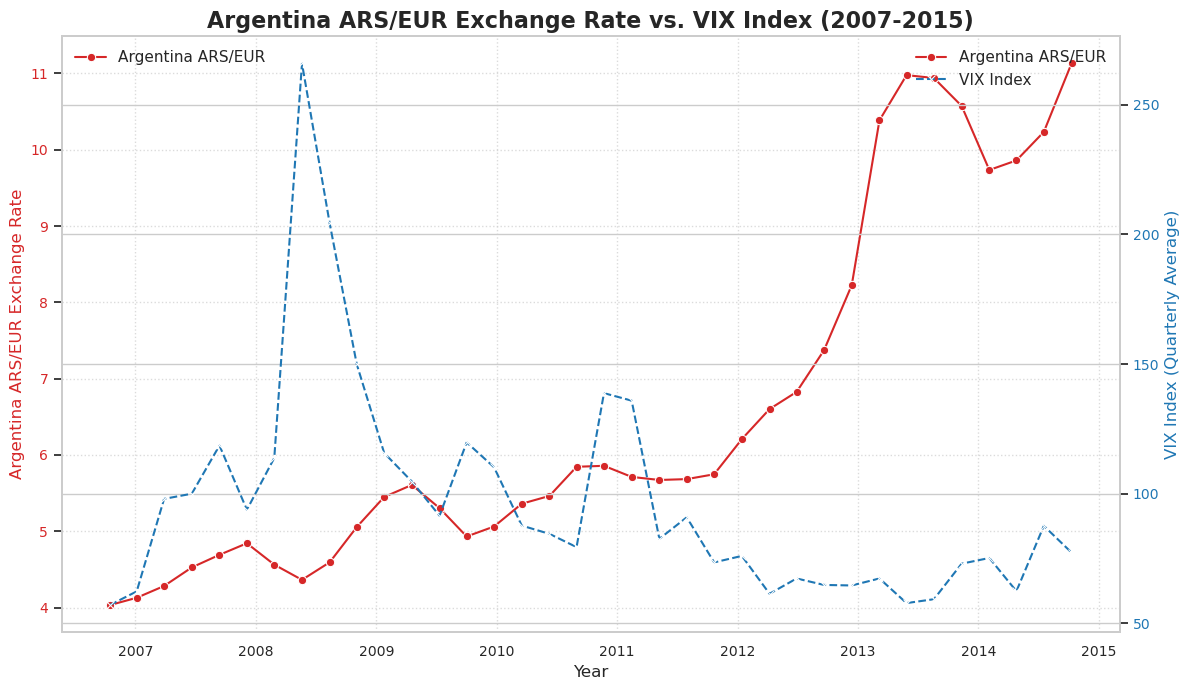


Correlation between Argentina ARS/EUR and VIX Index (2007-2015): -0.45
Interpretation: A strong positive correlation suggests that as global market volatility (VIX) increases, the Argentine Peso tends to depreciate against the Euro.
This can indicate financial contagion from global events (like the Eurozone crisis) impacting Argentina's currency.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_FX_FILE = "Argentina Exchange rate to euro.csv"
VIX_FILE = "VIXCLS CBOE Data for 2007 to2015.csv"

def load_and_process_argentina_fx(file_path):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0)

        print(f"\n--- Processing Argentina FX File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_argentina = df_raw[df_raw['COUNTRY'] == 'Argentina'].copy()
        if df_argentina.empty:
            print("Error: No data found for 'Argentina' in FX file. Check 'COUNTRY' column or value.")
            return pd.DataFrame()

        quarterly_cols = [col for col in df_argentina.columns if
                          (len(col) == 7 and col[4] == '-' and col[5] == 'Q' and col[:4].isdigit() and int(col[:4]) >= 2007 and int(col[:4]) <= 2015)]

        if not quarterly_cols:
            print("Error: No quarterly columns found for FX data (2007-2015). Check column names.")
            return pd.DataFrame()

        df_long = df_argentina.melt(
            id_vars=['COUNTRY', 'INDICATOR'],
            value_vars=quarterly_cols,
            var_name='Quarter_String',
            value_name='ARS_EUR'
        )

        df_long['Date'] = df_long['Quarter_String'].apply(lambda x: pd.Period(x, freq='Q').start_time)
        df_long.set_index('Date', inplace=True)
        
        df_long['ARS_EUR'] = pd.to_numeric(df_long['ARS_EUR'], errors='coerce')
        df_long.dropna(subset=['ARS_EUR'], inplace=True)

        print(f"Successfully processed Argentina FX data from {file_path}.")
        return df_long[['ARS_EUR']]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

def load_and_process_vix(file_path):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0)

        print(f"\n--- Processing VIX File: {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_vix = df_raw.rename(columns={'observation_date': 'Date', 'VIXCLS': 'VIX_Value'})
        
        df_vix['Date'] = pd.to_datetime(df_vix['Date'], errors='coerce')
        df_vix.set_index('Date', inplace=True)
        df_vix.dropna(subset=['VIX_Value'], inplace=True)

        df_vix = df_vix[(df_vix.index.year >= 2007) & (df_vix.index.year <= 2015)].copy()

        df_vix_quarterly = df_vix['VIX_Value'].resample('QS').mean().to_frame()

        print(f"Successfully processed VIX data from {file_path}.")
        return df_vix_quarterly

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()


df_argentina_fx = load_and_process_argentina_fx(ARGENTINA_FX_FILE)
df_vix = load_and_process_vix(VIX_FILE)

if not df_argentina_fx.empty and not df_vix.empty:
    df_merged = pd.merge(df_argentina_fx, df_vix, left_index=True, right_index=True, how='inner')
    
    if df_merged.empty:
        print("\nError: Merged DataFrame is empty. Check date ranges and data availability in both files.")
    elif len(df_merged) < 2:
        print("\nError: Not enough common data points after merging for plotting/correlation.")
    else:
        sns.set_theme(style="whitegrid")
        plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

        fig, ax1 = plt.subplots(figsize=(12, 7))

        color = 'tab:red'
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Argentina ARS/EUR Exchange Rate', color=color)
        sns.lineplot(x=df_merged.index, y='ARS_EUR', data=df_merged, ax=ax1, marker='o', linestyle='-', color=color, label='Argentina ARS/EUR', errorbar=None)
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.grid(True, linestyle=':', alpha=0.7)
        ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=10))

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('VIX Index (Quarterly Average)', color=color)
        sns.lineplot(x=df_merged.index, y='VIX_Value', data=df_merged, ax=ax2, marker='x', linestyle='--', color=color, label='VIX Index', errorbar=None)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper left')

        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.title('Argentina ARS/EUR Exchange Rate vs. VIX Index (2007-2015)', fontsize=16, fontweight='bold')
        fig.tight_layout()
        plt.show()

        correlation = df_merged['ARS_EUR'].corr(df_merged['VIX_Value'])
        print(f"\nCorrelation between Argentina ARS/EUR and VIX Index (2007-2015): {correlation:.2f}")
        print("Interpretation: A strong positive correlation suggests that as global market volatility (VIX) increases, the Argentine Peso tends to depreciate against the Euro.")
        print("This can indicate financial contagion from global events (like the Eurozone crisis) impacting Argentina's currency.")

else:
    print("\nCannot perform analysis.")


# Bond Yield Spread Analysis & Correlation Analysis

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

# --- Configuration and File Paths ---
ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
US_TREASURY_YIELD_FILE = "US Treasury Bond.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"
ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
GREECE_REAL_GDP_FILE = "Greece_Real_GDP_Annual_Corrected.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv" # This is the wide format file
GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

# --- Common Time Period for Analysis ---
START_DATE = '2007-01-01'
# FIX: Set END_DATE to '2018-01-01' to consistently include data up to 2017 for annual correlation
END_DATE = '2018-01-01' 

# --- Generic Data Loading and Processing Function for FRED CSVs (Long Format) ---
def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date, frequency='M', skip_rows=0):
    """
    Loads FRED CSV data (assumed to be in long format with 'observation_date' and value column),
    cleans it, filters by date, and resamples to specified frequency.
    Robustly handles column names by stripping all surrounding quotes and whitespace.
    Uses engine='python' for more flexible parsing.
    """
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        
        print(f"\n--- Processing FRED File (Long Format): {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging:")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        if 'observation_date' not in df_raw.columns:
            print(f"Error: 'observation_date' column not found in {file_path} after cleaning. Available columns: {df_raw.columns.tolist()}")
            return pd.DataFrame()
        
        if value_col_name not in df_raw.columns:
            print(f"Error: Value column '{value_col_name}' not found in {file_path} after cleaning. Available columns: {df_raw.columns.tolist()}")
            return pd.DataFrame()

        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data.dropna(subset=['Value'], inplace=True)

        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()

        if frequency == 'M':
            df_processed = df_data['Value'].resample('M').mean().to_frame()
        elif frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
            df_processed.rename_axis('Year', inplace=True)
        else:
            df_processed = df_data['Value'].to_frame()

        print(f"Successfully processed data from {file_path}.")
        return df_processed

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

# --- New Function for Wide Format FRED CSVs (like Argentina CPI and Greece GDP Corrected) ---
def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date, skip_rows=0):
    """
    Loads FRED CSV data (assumed to be in wide format with year columns),
    cleans it, filters by country and indicator, and melts to long format.
    Robustly handles column names with embedded quotes.
    """
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')

        print(f"\n--- Processing FRED File (Wide Format): {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging:")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        df_filtered = df_raw[
            (df_raw[country_col_name] == target_country) &
            (df_raw[indicator_col_name] == target_indicator_name)
        ].copy()

        if df_filtered.empty:
            print(f"No data found for {target_country} and {target_indicator_name} in {file_path}.")
            print(f"Available countries in '{country_col_name}': {df_raw[country_col_name].unique().tolist()}")
            print(f"Available indicators in '{indicator_col_name}': {df_raw[indicator_col_name].unique().tolist()}")
            return pd.DataFrame()

        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year - 1 # Exclude the end_date year itself

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) <= end_year_int]
        if not year_cols:
            print(f"Error: No year columns found from {start_year_int} to {end_year_int}. Check CSV structure.")
            return pd.DataFrame()

        df_long = df_filtered.melt(
            id_vars=[country_col_name, indicator_col_name],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        
        df_long.set_index('Year', inplace=True)
        df_long.rename_axis('Year', inplace=True)

        print(f"Successfully processed wide format data from {file_path} for {target_country} - {target_indicator_name}.")
        return df_long[['Value']]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()
df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, 'IRLTLT01GRM156N', START_DATE, END_DATE, frequency='M')
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, 'IRLTLT01DEM156N', START_DATE, END_DATE, frequency='M')
df_us_treasury_yield = load_and_process_fred_csv(US_TREASURY_YIELD_FILE, 'DGS10', START_DATE, END_DATE, frequency='M')
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, 'BAMLEMRLCRPILAOAS', START_DATE, END_DATE, frequency='M')

if not df_greek_yield.empty and not df_german_yield.empty:
    df_greece_spread_monthly = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_greece_spread_monthly['Greece_Spread'] = df_greece_spread_monthly['Value_Greece'] - df_greece_spread_monthly['Value_Germany']
    df_greece_spread_monthly = df_greece_spread_monthly[['Greece_Spread']]
    print("\nGreece Spread calculated successfully (Monthly).")
else:
    df_greece_spread_monthly = pd.DataFrame()
    print("\nCannot calculate Greece Spread (Monthly). Missing Greek or German yield data.")

df_bond_spreads_monthly = pd.DataFrame(index=pd.date_range(start=START_DATE, end=END_DATE, freq='MS'))
if not df_greece_spread_monthly.empty:
    df_bond_spreads_monthly = pd.merge(df_bond_spreads_monthly, df_greece_spread_monthly, left_index=True, right_index=True, how='left')
if not df_argentina_oas.empty:
    df_bond_spreads_monthly = pd.merge(df_bond_spreads_monthly, df_argentina_oas.rename(columns={'Value': 'Argentina_Spread'}), left_index=True, right_index=True, how='left')
else:
    print(f"Warning: df_argentina_oas is empty. Columns are: {df_argentina_oas.columns.tolist()}")


df_vix_monthly = load_and_process_fred_csv(VIX_FILE, 'VIXCLS', START_DATE, END_DATE, frequency='M')

df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, 'RGDPAARA666NRUG', START_DATE, END_DATE, frequency='A')
df_greece_gdp = load_and_process_wide_fred_csv(
    GREECE_REAL_GDP_FILE, 
    country_col_name='COUNTRY',
    indicator_col_name='INDICATOR',
    target_country='Greece', 
    target_indicator_name='Gross domestic product (GDP), Constant prices, Percent change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)

df_argentina_cpi = load_and_process_wide_fred_csv(
    ARGENTINA_CPI_FILE, 
    country_col_name='REF_AREA_NAME',
    indicator_col_name='INDICATOR_NAME',
    target_country='Argentina', 
    target_indicator_name='Inflation, annual % change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)
df_greece_cpi = load_and_process_fred_csv(GREECE_CPI_FILE, 'FPCPITOTLZGGRC', START_DATE, END_DATE, frequency='A')


df_bond_spreads_annual = df_bond_spreads_monthly.resample('Y').mean()
df_bond_spreads_annual.index = df_bond_spreads_annual.index.year
df_bond_spreads_annual.rename_axis('Year', inplace=True)

df_vix_annual = df_vix_monthly.resample('Y').mean()
df_vix_annual.index = df_vix_annual.index.year
df_vix_annual.rename_axis('Year', inplace=True)
df_vix_annual.rename(columns={'Value': 'VIX_Value'}, inplace=True)


df_correlation_data = pd.DataFrame(index=df_bond_spreads_annual.index)
df_correlation_data = pd.merge(df_correlation_data, df_bond_spreads_annual, on='Year', how='left')
df_correlation_data = pd.merge(df_correlation_data, df_vix_annual, on='Year', how='left')

if not df_argentina_gdp.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_argentina_gdp.rename(columns={'Value': 'Argentina_GDP_Growth'}), on='Year', how='left')
if not df_greece_gdp.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_greece_gdp.rename(columns={'Value': 'Greece_GDP_Growth'}), on='Year', how='left')
if not df_argentina_cpi.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_argentina_cpi.rename(columns={'Value': 'Argentina_Inflation'}), on='Year', how='left')
if not df_greece_cpi.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_greece_cpi.rename(columns={'Value': 'Greece_Inflation'}), on='Year', how='left')

print("\n--- df_correlation_data info() before final dropna ---")
df_correlation_data.info()
print("\n--- df_correlation_data head() before final dropna ---")
print(df_correlation_data.head().to_string())
print("\n--- df_correlation_data to_string() before final dropna ---")
print(df_correlation_data.to_string())

df_correlation_data.dropna(inplace=True)

if df_correlation_data.empty or len(df_correlation_data) < 2:
    print("\nNot enough common data points after merging for correlation analysis. Check data ranges and NaNs.")
else:
    print("\n--- Final Correlation Data Head ---")
    print(df_correlation_data.head().to_string())
    print("\n--- Bond Yield Spread Analysis & Correlation Analysis ---")

    if not df_bond_spreads_monthly.empty:
        plt.figure(figsize=(14, 8))
        if 'Greece_Spread' in df_bond_spreads_monthly.columns:
            sns.lineplot(x=df_bond_spreads_monthly.index, y='Greece_Spread', data=df_bond_spreads_monthly, marker='o', label='Greece 10Y Spread (pp)', color='red', errorbar=None)
        if 'Argentina_Spread' in df_bond_spreads_monthly.columns:
            sns.lineplot(x=df_bond_spreads_monthly.index, y='Argentina_Spread', data=df_bond_spreads_monthly, marker='x', linestyle='--', label='Argentina OAS (bps)', color='blue', errorbar=None)
        plt.title('Government Bond Yield Spreads: Greece vs. Argentina (Monthly, 2007-2017)')
        plt.xlabel('Date')
        plt.ylabel('Spread')
        plt.legend()
        plt.grid(True)
        plt.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

    print("\nCorrelation Matrix (Annual Data):")
    correlation_cols = [
        'Greece_Spread', 'Argentina_Spread', 'VIX_Value',
        'Greece_GDP_Growth', 'Argentina_GDP_Growth',
        'Greece_Inflation', 'Argentina_Inflation'
    ]
    
    actual_correlation_cols = [col for col in correlation_cols if col in df_correlation_data.columns]
    
    if len(actual_correlation_cols) > 1:
        correlation_matrix = df_correlation_data[actual_correlation_cols].corr()
        print(correlation_matrix.round(2))

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Key Indicators (Annual, 2007-2017)')
        plt.show()

        print("\n--- Interpretation of Correlation Analysis ---")
        print("Correlation coefficients range from -1 to +1.")
        print("  +1: Perfect positive correlation (variables move in the same direction).")
        print("  -1: Perfect negative correlation (variables move in opposite directions).")
        print("   0: No linear correlation.")
        print("Look for strong positive correlations between spreads and VIX (global risk).")
        print("Look for negative correlations between spreads and GDP growth (higher spread, lower growth).")
        print("Compare correlations for Greece and Argentina to see those differences in market reactions.")
    else:
        print("\nNot enough relevant columns to compute correlation matrix.")


--- Processing FRED File (Long Format): Greek 10 year bond yield data alongwith benchmark.csv ---
Columns detected after initial CSV load:
['observation_date', 'IRLTLT01GRM156N']
Raw (repr) of columns for debugging:
["'observation_date'", "'IRLTLT01GRM156N'"]
First 5 rows of raw data:
  observation_date  IRLTLT01GRM156N
0       2007-01-01             4.28
1       2007-02-01             4.30
2       2007-03-01             4.20
3       2007-04-01             4.40
4       2007-05-01             4.51
Successfully processed data from Greek 10 year bond yield data alongwith benchmark.csv.

--- Processing FRED File (Long Format): German bond yield.csv ---
Columns detected after initial CSV load:
['observation_date', 'IRLTLT01DEM156N']
Raw (repr) of columns for debugging:
["'observation_date'", "'IRLTLT01DEM156N'"]
First 5 rows of raw data:
  observation_date  IRLTLT01DEM156N
0       2007-01-01         4.016818
1       2007-02-01         4.049000
2       2007-03-01         3.940909
3       20


--- Processing FRED File (Long Format): VIXCLS data 2007 to 2018.csv ---
Raw data head (before header processing):
  observation_date  VIXCLS
0       2007-01-01   11.04
1       2007-02-01   11.16
2       2007-03-01   15.16
3       2007-04-01   12.93
4       2007-05-01   13.30
Columns detected after initial CSV load (cleaned):
['observation_date', 'VIXCLS']
Raw (repr) of columns for debugging (cleaned):
["'observation_date'", "'VIXCLS'"]
First 5 rows of raw data (after header processing and cleaning):
  observation_date  VIXCLS
0       2007-01-01   11.04
1       2007-02-01   11.16
2       2007-03-01   15.16
3       2007-04-01   12.93
4       2007-05-01   13.30
Successfully processed data from VIXCLS data 2007 to 2018.csv.

--- Processing FRED File (Long Format): Argentina_Real_GDP_Annual.csv ---
Raw data head (before header processing):
  observation_date  RGDPNAARA666NRUG
0       2007-01-01               9.0
1       2008-01-01               4.1
2       2009-01-01              -5.9
3  

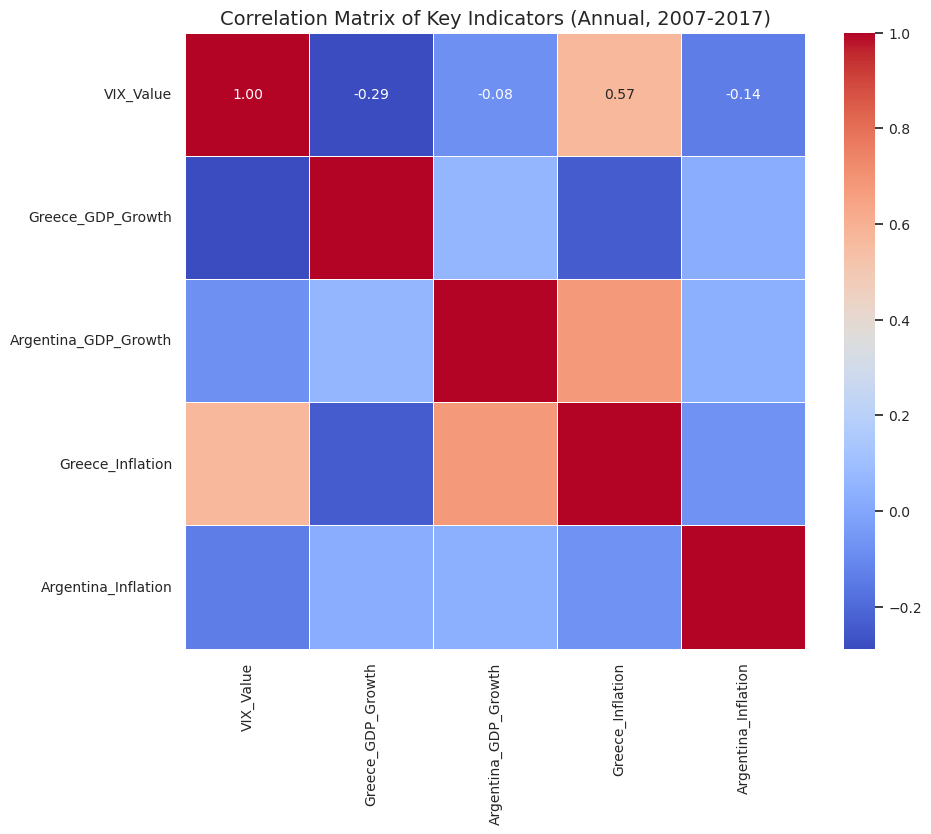


--- Interpretation of Correlation Analysis ---
Correlation coefficients range from -1 to +1.
  +1: Perfect positive correlation (variables move in the same direction).
  -1: Perfect negative correlation (variables move in opposite directions).
   0: No linear correlation.
Look for strong positive correlations between VIX and other indicators (e.g., higher VIX, lower GDP growth).
Compare correlations for Greece and Argentina to see those differences in market reactions.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

VIX_FILE = "VIXCLS data 2007 to 2018.csv"
ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
GREECE_REAL_GDP_FILE = "Greece_Real_GDP_Annual_Corrected.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv" 
GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

START_DATE = '2007-01-01'
END_DATE = '2018-01-01' 

def load_and_process_fred_csv(file_path, start_date, end_date, frequency='M', skip_rows=0):

    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        
        print(f"\n--- Processing FRED File (Long Format): {file_path} ---")
        print("Raw data head (before header processing):")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        print("Columns detected after initial CSV load (cleaned):")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging (cleaned):")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data (after header processing and cleaning):")
        print(df_raw.head().to_string())


        if 'observation_date' not in df_raw.columns:
            print(f"Error: 'observation_date' column not found in {file_path} after cleaning. Available columns: {df_raw.columns.tolist()}")
            return pd.DataFrame()
        
        if len(df_raw.columns) < 2:
            print(f"Error: Not enough columns in {file_path}. Expected at least 2 (observation_date and value).")
            return pd.DataFrame()
        
        original_value_col_name_at_index_1 = df_raw.columns[1]

        df_data = df_raw.rename(columns={'observation_date': 'Date', original_value_col_name_at_index_1: 'Value'})
        
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data.dropna(subset=['Value'], inplace=True)

        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()

        if frequency == 'M':
            df_processed = df_data['Value'].resample('M').mean().to_frame()
        elif frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
            df_processed.rename_axis('Year', inplace=True)
        else:
            df_processed = df_data['Value'].to_frame()

        print(f"Successfully processed data from {file_path}.")
        return df_processed

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date, skip_rows=0):
   
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')

        print(f"\n--- Processing FRED File (Wide Format): {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging:")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        df_filtered = df_raw[
            (df_raw[country_col_name] == target_country) &
            (df_raw[indicator_col_name] == target_indicator_name)
        ].copy()

        if df_filtered.empty:
            print(f"No data found for {target_country} and {target_indicator_name} in {file_path}.")
            print(f"Available countries in '{country_col_name}': {df_raw[country_col_name].unique().tolist()}")
            print(f"Available indicators in '{indicator_col_name}': {df_raw[indicator_col_name].unique().tolist()}")
            return pd.DataFrame()

        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year - 1

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) <= end_year_int]
        if not year_cols:
            print(f"Error: No year columns found from {start_year_int} to {end_year_int}. Check CSV structure.")
            return pd.DataFrame()

        df_long = df_filtered.melt(
            id_vars=[country_col_name, indicator_col_name],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        
        df_long['Value'] = df_long['Value'].astype(str).str.replace(',', '', regex=False)
        df_long['Value'] = df_long['Value'].astype(str).str.replace(' ', '', regex=False)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        
        df_long.set_index('Year', inplace=True)
        df_long.rename_axis('Year', inplace=True)

        print(f"Successfully processed wide format data from {file_path} for {target_country} - {target_indicator_name}.")
        return df_long[['Value']]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()
        
df_greece_spread_monthly = pd.DataFrame() 
df_argentina_oas = pd.DataFrame() 

df_vix_monthly = load_and_process_fred_csv(VIX_FILE, START_DATE, END_DATE, frequency='M')

df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, START_DATE, END_DATE, frequency='A')
df_greece_gdp = load_and_process_wide_fred_csv(
    GREECE_REAL_GDP_FILE, 
    country_col_name='COUNTRY',
    indicator_col_name='INDICATOR',
    target_country='Greece', 
    target_indicator_name='Gross domestic product (GDP), Constant prices, Percent change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)

df_argentina_cpi = load_and_process_wide_fred_csv(
    ARGENTINA_CPI_FILE, 
    country_col_name='REF_AREA_NAME',
    indicator_col_name='INDICATOR_NAME',
    target_country='Argentina', 
    target_indicator_name='Inflation, annual % change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)
df_greece_cpi = load_and_process_fred_csv(GREECE_CPI_FILE, START_DATE, END_DATE, frequency='A')


df_vix_annual = df_vix_monthly.resample('Y').mean()
df_vix_annual.index = df_vix_annual.index.year
df_vix_annual.rename_axis('Year', inplace=True)
df_vix_annual.rename(columns={'Value': 'VIX_Value'}, inplace=True)

df_correlation_data = pd.DataFrame(index=df_vix_annual.index) 
df_correlation_data = pd.merge(df_correlation_data, df_vix_annual, on='Year', how='left')

if not df_argentina_gdp.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_argentina_gdp.rename(columns={'Value': 'Argentina_GDP_Growth'}), on='Year', how='left')
if not df_greece_gdp.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_greece_gdp.rename(columns={'Value': 'Greece_GDP_Growth'}), on='Year', how='left')
if not df_argentina_cpi.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_argentina_cpi.rename(columns={'Value': 'Argentina_Inflation'}), on='Year', how='left')
if not df_greece_cpi.empty:
    df_correlation_data = pd.merge(df_correlation_data, df_greece_cpi.rename(columns={'Value': 'Greece_Inflation'}), on='Year', how='left')

print("\n--- df_correlation_data info() before final dropna ---")
df_correlation_data.info()
print("\n--- df_correlation_data head() before final dropna ---")
print(df_correlation_data.head().to_string())
print("\n--- df_correlation_data to_string() before final dropna ---")
print(df_correlation_data.to_string())

df_correlation_data.dropna(inplace=True)

if df_correlation_data.empty or len(df_correlation_data) < 2:
    print("\nNot enough common data points after merging for correlation analysis. Check data ranges and NaNs.")
else:
    print("\n--- Final Correlation Data Head ---")
    print(df_correlation_data.head().to_string())
    print("\n--- Bond Yield Spread Analysis & Correlation Analysis ---")

    print("\nMonthly Bond Yield Spreads plot skipped as per simplified analysis.")

    print("\nCorrelation Matrix (Annual Data):")
    correlation_cols = [
        'VIX_Value',
        'Greece_GDP_Growth', 'Argentina_GDP_Growth',
        'Greece_Inflation', 'Argentina_Inflation'
    ]
    
    actual_correlation_cols = [col for col in correlation_cols if col in df_correlation_data.columns]
    
    if len(actual_correlation_cols) > 1:
        correlation_matrix = df_correlation_data[actual_correlation_cols].corr()
        print(correlation_matrix.round(2))

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Key Indicators (Annual, 2007-2017)')
        plt.show()

        print("\n--- Interpretation of Correlation Analysis ---")
        print("Correlation coefficients range from -1 to +1.")
        print("  +1: Perfect positive correlation (variables move in the same direction).")
        print("  -1: Perfect negative correlation (variables move in opposite directions).")
        print("   0: No linear correlation.")
        print("Look for strong positive correlations between VIX and other indicators (e.g., higher VIX, lower GDP growth).")
        print("Compare correlations for Greece and Argentina to see those differences in market reactions.")
    else:
        print("\nNot enough relevant columns to compute correlation matrix.")


--- Processing FRED File (Long Format): Greek 10 year bond yield data alongwith benchmark.csv ---
Raw data head (before header processing):
  observation_date  IRLTLT01GRM156N
0       2007-01-01             4.28
1       2007-02-01             4.30
2       2007-03-01             4.20
3       2007-04-01             4.40
4       2007-05-01             4.51
Columns detected after initial CSV load (cleaned):
['observation_date', 'IRLTLT01GRM156N']
Raw (repr) of columns for debugging (cleaned):
["'observation_date'", "'IRLTLT01GRM156N'"]
First 5 rows of raw data (after header processing and cleaning):
  observation_date  IRLTLT01GRM156N
0       2007-01-01             4.28
1       2007-02-01             4.30
2       2007-03-01             4.20
3       2007-04-01             4.40
4       2007-05-01             4.51
Successfully processed data from Greek 10 year bond yield data alongwith benchmark.csv.

--- Processing FRED File (Long Format): German bond yield.csv ---
Raw data head (before hea

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


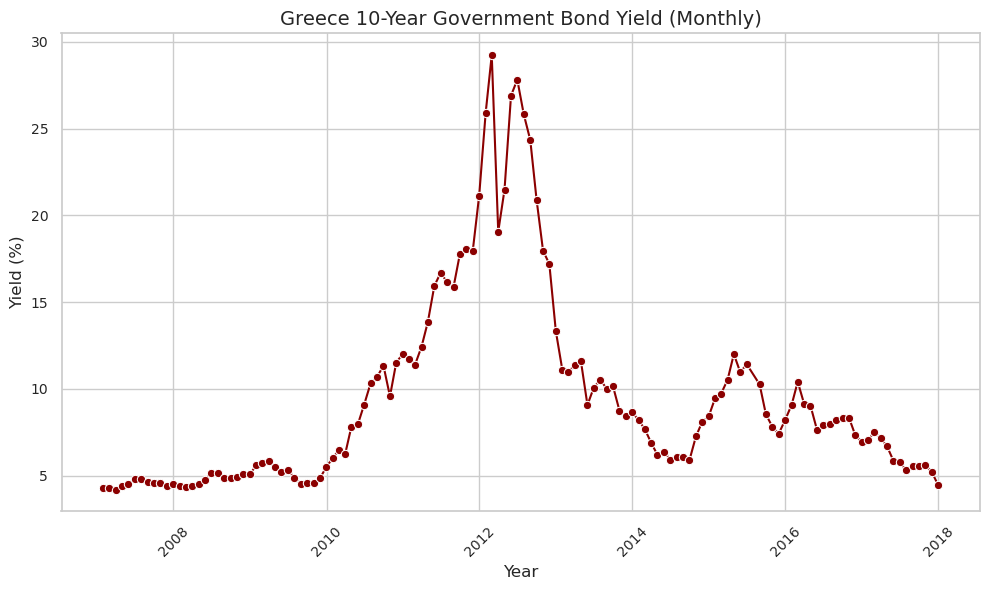

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


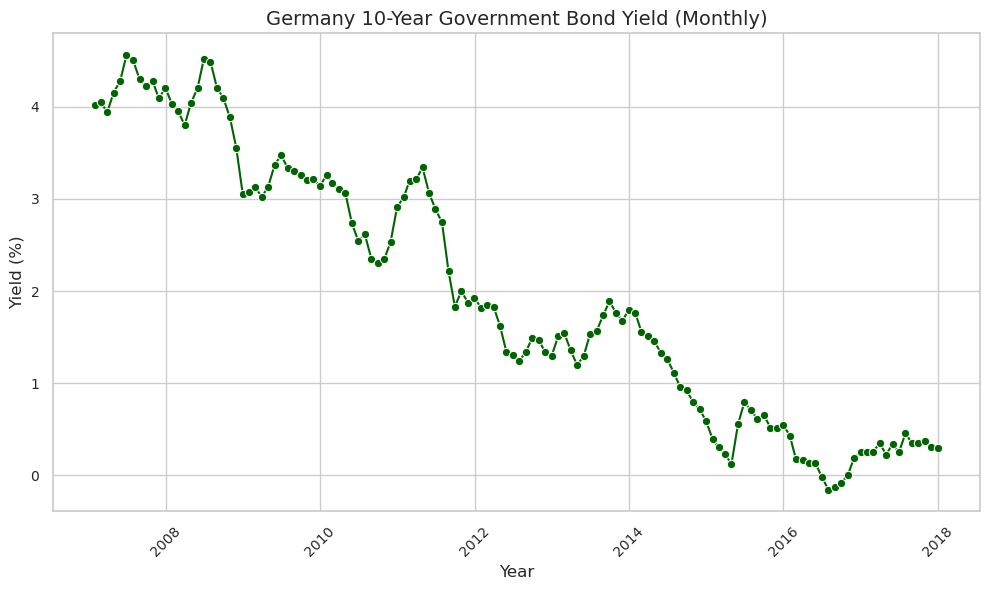

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


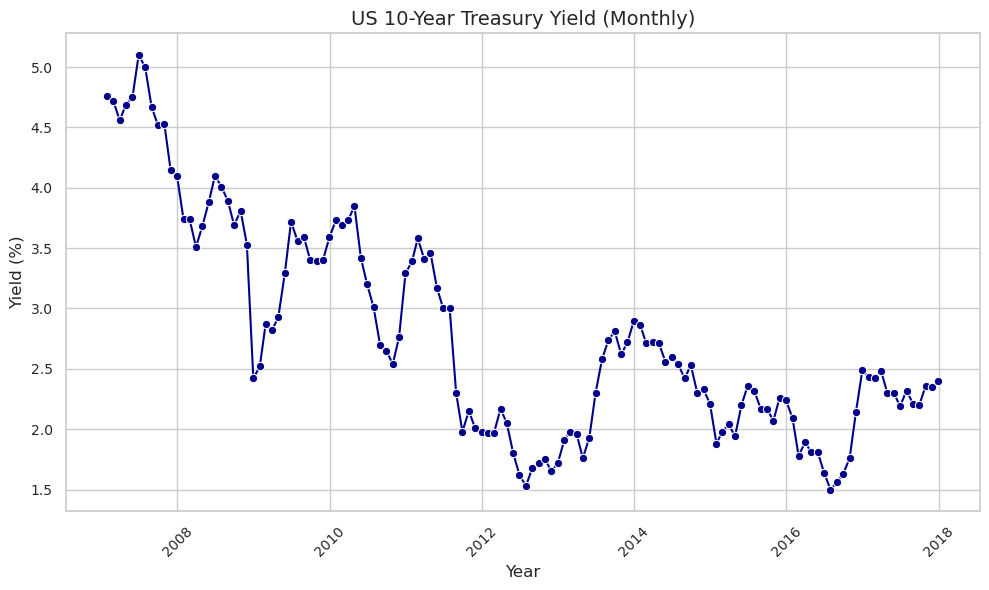

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


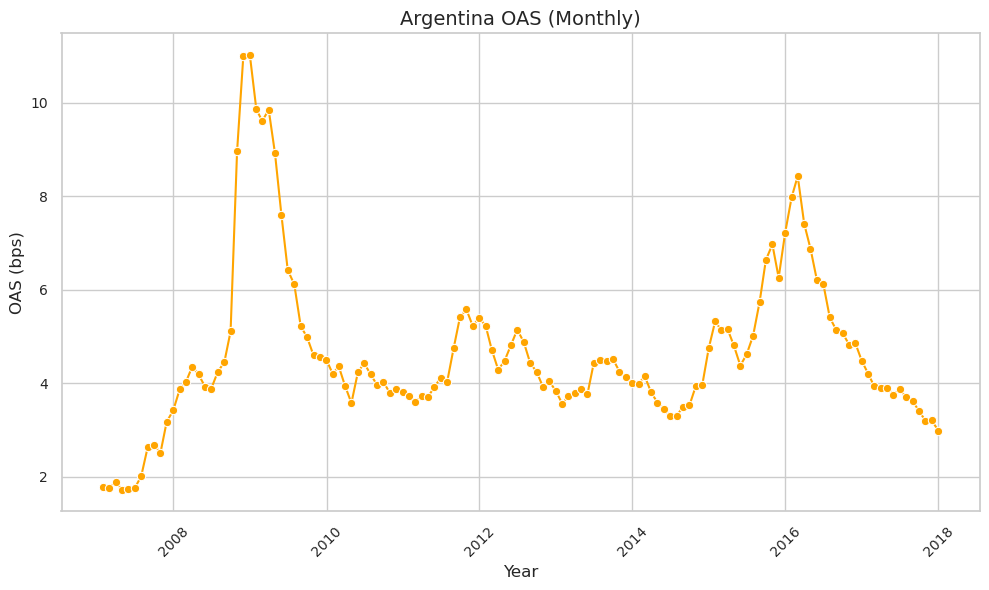

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


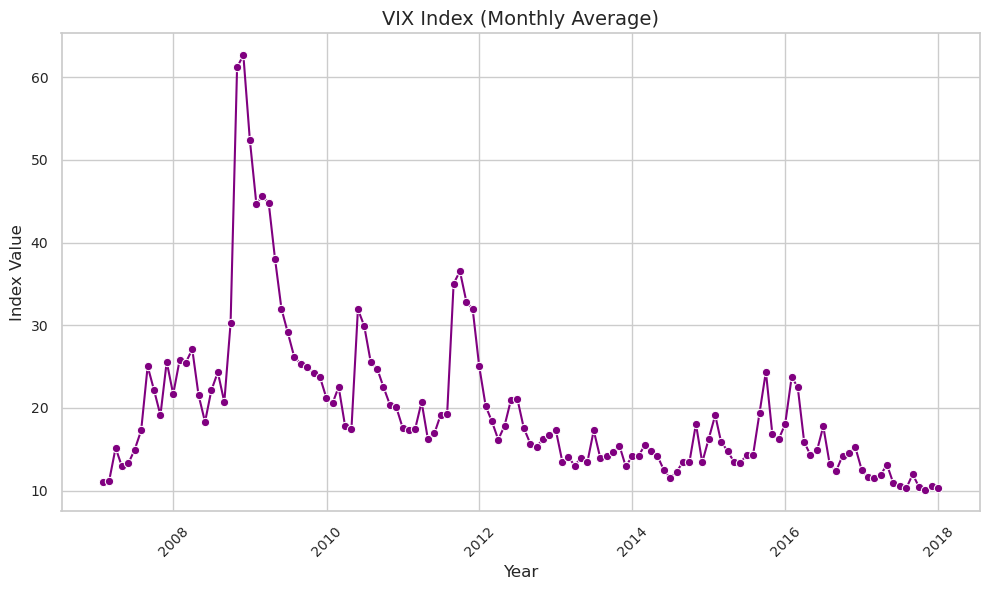

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


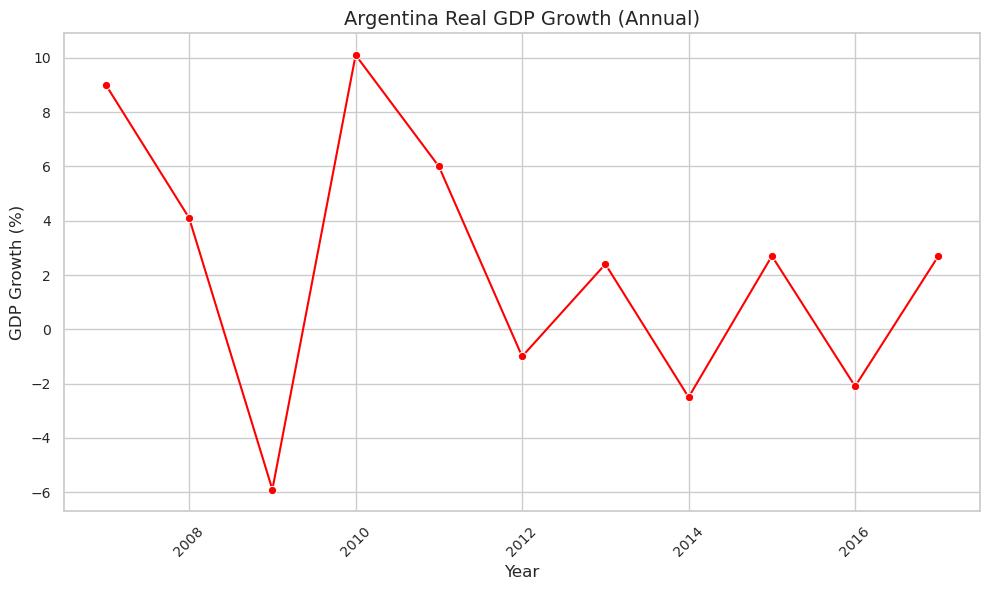

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


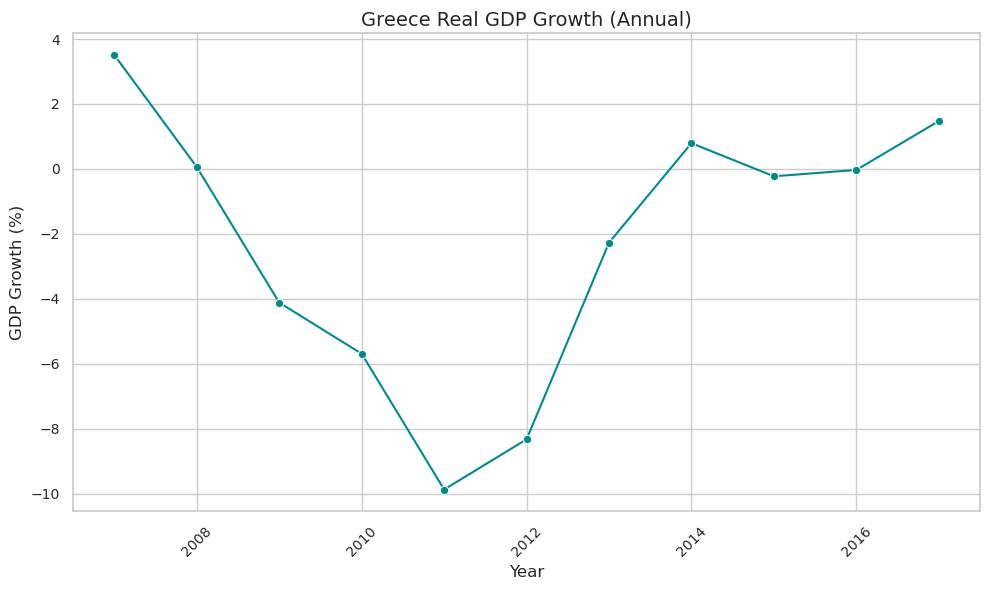

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


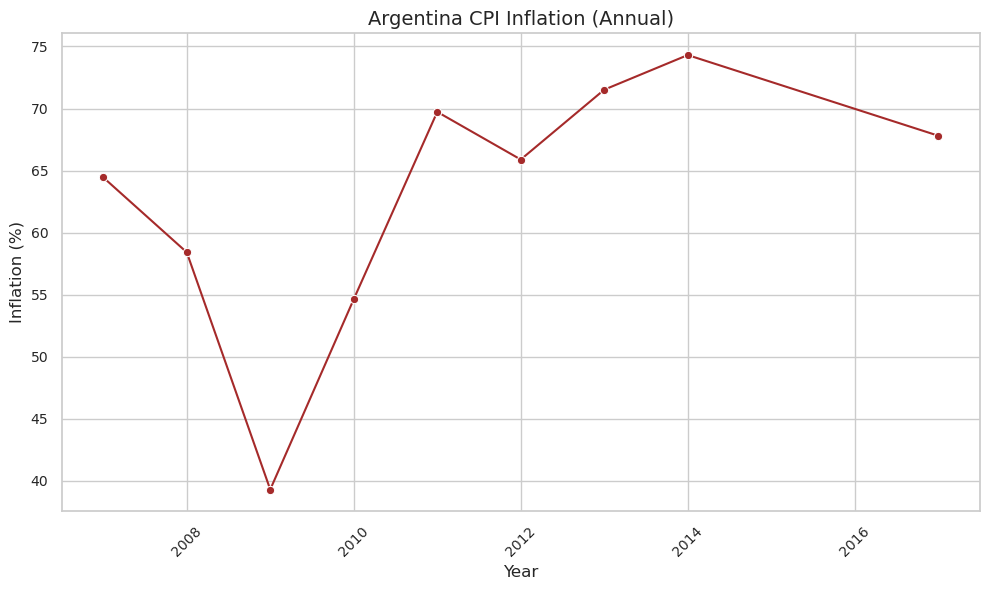

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


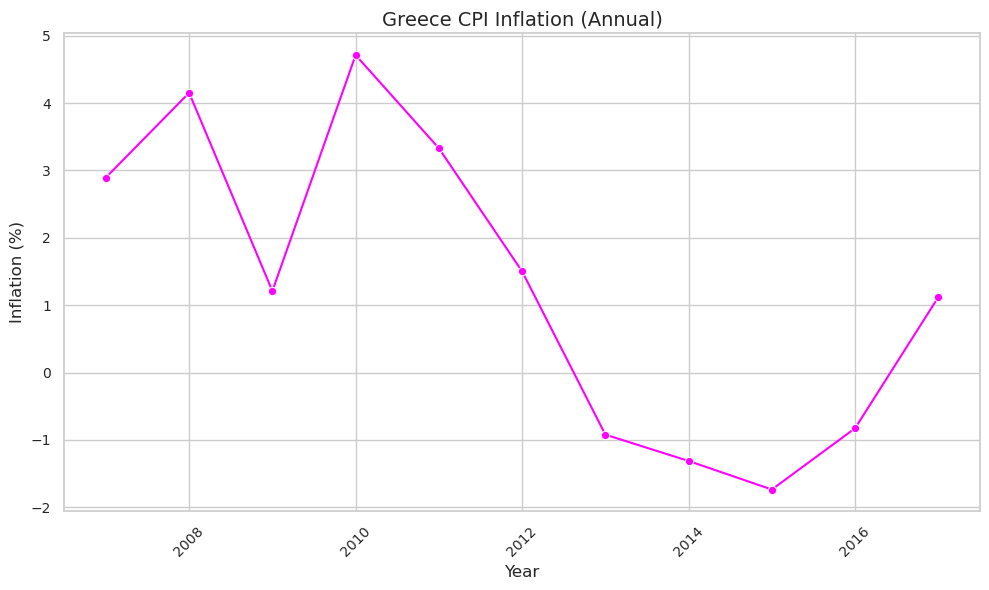

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
US_TREASURY_YIELD_FILE = "US Treasury Bond.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"
ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
GREECE_REAL_GDP_FILE = "Greece_Real_GDP_Annual_Corrected.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv" 
GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

START_DATE = '2007-01-01'
END_DATE = '2018-01-01' 

def load_and_process_fred_csv(file_path, start_date, end_date, frequency='M', skip_rows=0):
    
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        
        print(f"\n--- Processing FRED File (Long Format): {file_path} ---")
        print("Raw data head (before header processing):")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        print("Columns detected after initial CSV load (cleaned):")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging (cleaned):")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data (after header processing and cleaning):")
        print(df_raw.head().to_string())


        if 'observation_date' not in df_raw.columns:
            print(f"Error: 'observation_date' column not found in {file_path} after cleaning. Available columns: {df_raw.columns.tolist()}")
            return pd.DataFrame()
        
        if len(df_raw.columns) < 2:
            print(f"Error: Not enough columns in {file_path}. Expected at least 2 (observation_date and value).")
            return pd.DataFrame()
        
        original_value_col_name_at_index_1 = df_raw.columns[1]

        df_data = df_raw.rename(columns={'observation_date': 'Date', original_value_col_name_at_index_1: 'Value'})
        
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data.dropna(subset=['Value'], inplace=True)

        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()

        if frequency == 'M':
            df_processed = df_data['Value'].resample('M').mean().to_frame()
        elif frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
            df_processed.rename_axis('Year', inplace=True)
        else:
            df_processed = df_data['Value'].to_frame()

        print(f"Successfully processed data from {file_path}.")
        return df_processed

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date, skip_rows=0):
    
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')

        print(f"\n--- Processing FRED File (Wide Format): {file_path} ---")
        print("Columns detected after initial CSV load:")
        print(df_raw.columns.tolist())
        print("Raw (repr) of columns for debugging:")
        print([repr(col) for col in df_raw.columns.tolist()])
        print("First 5 rows of raw data:")
        print(df_raw.head().to_string())

        df_raw.columns = [col.strip().replace("'", "").replace('"', '') for col in df_raw.columns]

        df_filtered = df_raw[
            (df_raw[country_col_name] == target_country) &
            (df_raw[indicator_col_name] == target_indicator_name)
        ].copy()

        if df_filtered.empty:
            print(f"No data found for {target_country} and {target_indicator_name} in {file_path}.")
            print(f"Available countries in '{country_col_name}': {df_raw[country_col_name].unique().tolist()}")
            print(f"Available indicators in '{indicator_col_name}': {df_raw[indicator_col_name].unique().tolist()}")
            return pd.DataFrame()

        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year - 1

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) <= end_year_int]
        if not year_cols:
            print(f"Error: No year columns found from {start_year_int} to {end_year_int}. Check CSV structure.")
            return pd.DataFrame()

        df_long = df_filtered.melt(
            id_vars=[country_col_name, indicator_col_name],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )

        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        
        df_long['Value'] = df_long['Value'].astype(str).str.replace(',', '', regex=False)
        df_long['Value'] = df_long['Value'].astype(str).str.replace(' ', '', regex=False)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        
        df_long.set_index('Year', inplace=True)
        df_long.rename_axis('Year', inplace=True)

        print(f"Successfully processed wide format data from {file_path} for {target_country} - {target_indicator_name}.")
        return df_long[['Value']]

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}. Please check the path and filename.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, START_DATE, END_DATE, frequency='M')
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, START_DATE, END_DATE, frequency='M')
df_us_treasury_yield = load_and_process_fred_csv(US_TREASURY_YIELD_FILE, START_DATE, END_DATE, frequency='M')
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, START_DATE, END_DATE, frequency='M')

if not df_greek_yield.empty and not df_german_yield.empty:
    df_greece_spread_monthly = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_greece_spread_monthly['Greece_Spread'] = df_greece_spread_monthly['Value_Greece'] - df_greece_spread_monthly['Value_Germany']
    df_greece_spread_monthly = df_greece_spread_monthly[['Greece_Spread']]
    print("\nGreece Spread calculated successfully (Monthly).")
else:
    df_greece_spread_monthly = pd.DataFrame()
    print("\nCannot calculate Greece Spread (Monthly). Missing Greek or German yield data.")

df_bond_spreads_monthly = pd.DataFrame(index=pd.date_range(start=START_DATE, end=END_DATE, freq='MS'))
if not df_greece_spread_monthly.empty:
    df_bond_spreads_monthly = pd.merge(df_bond_spreads_monthly, df_greece_spread_monthly, left_index=True, right_index=True, how='left')
if not df_argentina_oas.empty:
    df_bond_spreads_monthly = pd.merge(df_bond_spreads_monthly, df_argentina_oas.rename(columns={'Value': 'Argentina_Spread'}), left_index=True, right_index=True, how='left')
else:
    print(f"Warning: df_argentina_oas is empty. Columns are: {df_argentina_oas.columns.tolist()}")


df_vix_monthly = load_and_process_fred_csv(VIX_FILE, START_DATE, END_DATE, frequency='M')

df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, START_DATE, END_DATE, frequency='A')
df_greece_gdp = load_and_process_wide_fred_csv(
    GREECE_REAL_GDP_FILE, 
    country_col_name='COUNTRY',
    indicator_col_name='INDICATOR',
    target_country='Greece', 
    target_indicator_name='Gross domestic product (GDP), Constant prices, Percent change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)

df_argentina_cpi = load_and_process_wide_fred_csv(
    ARGENTINA_CPI_FILE, 
    country_col_name='REF_AREA_NAME',
    indicator_col_name='INDICATOR_NAME',
    target_country='Argentina', 
    target_indicator_name='Inflation, annual % change',
    start_date=START_DATE, 
    end_date=END_DATE, 
    skip_rows=0
)
df_greece_cpi = load_and_process_fred_csv(GREECE_CPI_FILE, START_DATE, END_DATE, frequency='A')


sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 12, 'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10})

print("\n--- Generating Individual Plots to Inspect Data Availability ---")

#  Greece 10Y Yield
if not df_greek_yield.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_greek_yield.index, y='Value', data=df_greek_yield, marker='o', color='darkred', errorbar=None)
    plt.title('Greece 10-Year Government Bond Yield (Monthly)')
    plt.xlabel('Year')
    plt.ylabel('Yield (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: Greece 10Y Yield data is empty.")

#  German 10Y Yield
if not df_german_yield.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_german_yield.index, y='Value', data=df_german_yield, marker='o', color='darkgreen', errorbar=None)
    plt.title('Germany 10-Year Government Bond Yield (Monthly)')
    plt.xlabel('Year')
    plt.ylabel('Yield (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: German 10Y Yield data is empty.")

#  US Treasury 10Y Yield
if not df_us_treasury_yield.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_us_treasury_yield.index, y='Value', data=df_us_treasury_yield, marker='o', color='darkblue', errorbar=None)
    plt.title('US 10-Year Treasury Yield (Monthly)')
    plt.xlabel('Year')
    plt.ylabel('Yield (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: US 10Y Treasury Yield data is empty.")

#  Argentina OAS
if not df_argentina_oas.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_argentina_oas.index, y='Value', data=df_argentina_oas, marker='o', color='orange', errorbar=None)
    plt.title('Argentina OAS (Monthly)')
    plt.xlabel('Year')
    plt.ylabel('OAS (bps)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: Argentina OAS data is empty.")

#  VIX Index
if not df_vix_monthly.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_vix_monthly.index, y='Value', data=df_vix_monthly, marker='o', color='purple', errorbar=None)
    plt.title('VIX Index (Monthly Average)')
    plt.xlabel('Year')
    plt.ylabel('Index Value')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: VIX Index data is empty.")

# Argentina Real GDP Annual
if not df_argentina_gdp.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_argentina_gdp.index, y='Value', data=df_argentina_gdp, marker='o', color='red', errorbar=None)
    plt.title('Argentina Real GDP Growth (Annual)')
    plt.xlabel('Year')
    plt.ylabel('GDP Growth (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: Argentina Real GDP data is empty.")

#  Greece Real GDP Annual
if not df_greece_gdp.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_greece_gdp.index, y='Value', data=df_greece_gdp, marker='o', color='darkcyan', errorbar=None)
    plt.title('Greece Real GDP Growth (Annual)')
    plt.xlabel('Year')
    plt.ylabel('GDP Growth (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: Greece Real GDP data is empty.")

# Argentina CPI Annual
if not df_argentina_cpi.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_argentina_cpi.index, y='Value', data=df_argentina_cpi, marker='o', color='brown', errorbar=None)
    plt.title('Argentina CPI Inflation (Annual)')
    plt.xlabel('Year')
    plt.ylabel('Inflation (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Plot skipped: Argentina CPI data is empty.")

#  Greece CPI Annual
if not df_greece_cpi.empty:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df_greece_cpi.index, y='Value', data=df_greece_cpi, marker='o', color='magenta', errorbar=None)
    plt.title('Greece CPI Inflation (Annual)')
    plt.xlabel('Year')
    plt.ylabel('Inflation (%)')
    plt.grid(True)
    plt.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
else: print("Greece CPI data is empty.")


Successfully processed data from Greek 10 year bond yield data alongwith benchmark.csv.
Successfully processed data from German bond yield.csv.
Successfully processed data from Argentina_LATAM_EM_OAS.csv.
Successfully processed data from VIXCLS data 2007 to 2018.csv.
Successfully processed data from Argentina_Real_GDP_Annual.csv.
Successfully processed wide format data from Greece_Real_GDP_Annual_Corrected.csv.
Successfully processed wide format data from Inflation data for argentina %change.csv.
Successfully processed data from Greece CPI Inflation 2007 to 2018.csv.

Greece Spread calculated successfully (Monthly).

--- Correlation Matrix (Annual Data) ---
                      Greece_Spread  Argentina_Spread  VIX_Value  \
Greece_Spread                  1.00             -0.05      -0.29   
Argentina_Spread              -0.05              1.00       0.78   
VIX_Value                     -0.29              0.78       1.00   
Argentina_GDP_Growth          -0.14             -0.59      -0.

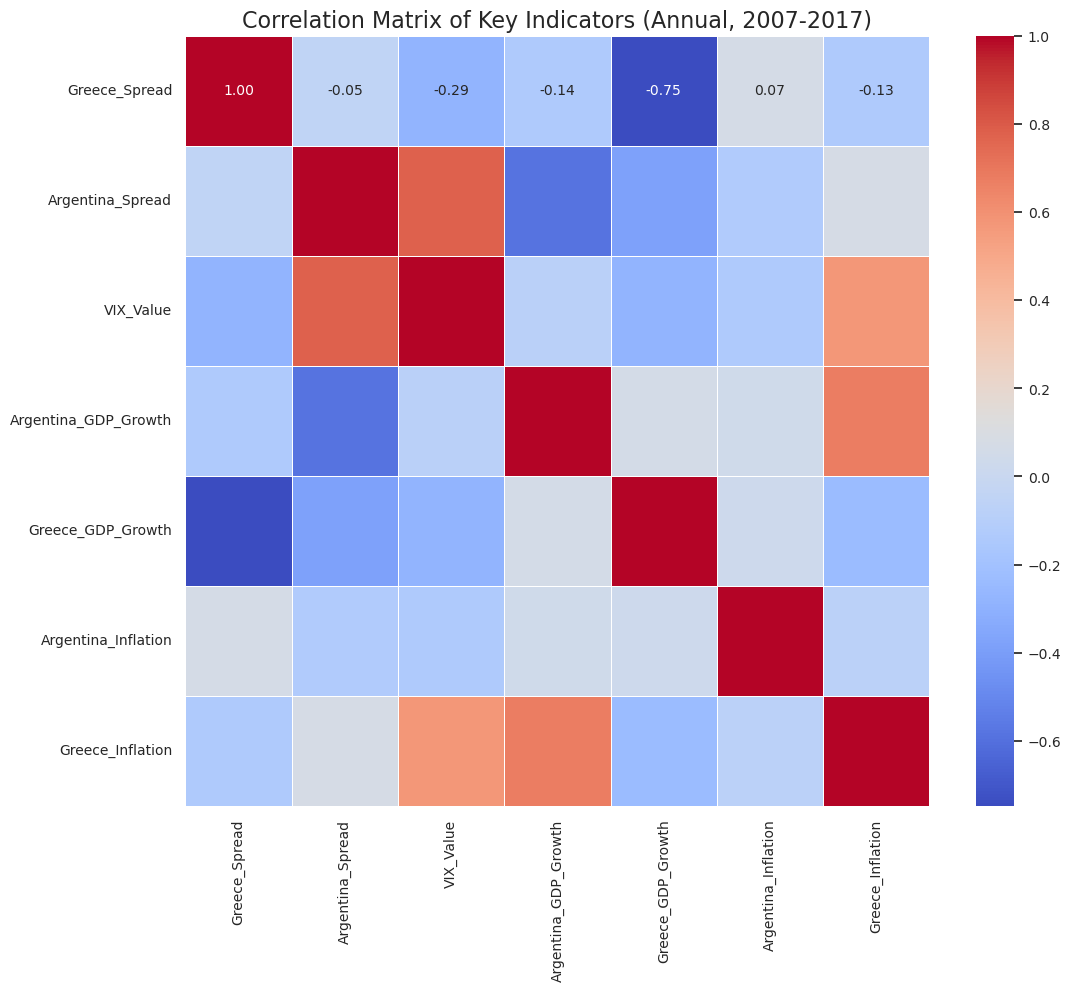

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
US_TREASURY_YIELD_FILE = "US Treasury Bond.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"
ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
GREECE_REAL_GDP_FILE = "Greece_Real_GDP_Annual_Corrected.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv"
GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

START_DATE = '2007-01-01'
END_DATE = '2018-01-01'

def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date, frequency='M', skip_rows=0):
   
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        # Clean column names robustly
        df_raw.columns = [col.strip().strip("'\"") for col in df_raw.columns]

        if 'observation_date' not in df_raw.columns or value_col_name not in df_raw.columns:
            print(f"Error: Required columns ('observation_date' or '{value_col_name}') not found in {file_path}.")
            return pd.DataFrame()

        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        # Convert value column to numeric, coercing errors
        df_data['Value'] = pd.to_numeric(df_data['Value'], errors='coerce')
        df_data.dropna(subset=['Value'], inplace=True)
        
        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()
        
        if frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
        else: # Default to monthly
            df_processed = df_data['Value'].resample('M').mean().to_frame()

        print(f"Successfully processed data from {file_path}.")
        return df_processed
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date, skip_rows=0):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        df_raw.columns = [col.strip().strip("'\"") for col in df_raw.columns]
        
        df_filtered = df_raw[
            (df_raw[country_col_name] == target_country) &
            (df_raw[indicator_col_name] == target_indicator_name)
        ].copy()

        if df_filtered.empty:
            print(f"No data found for {target_country} and {target_indicator_name} in {file_path}.")
            return pd.DataFrame()

        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year

        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) < end_year_int]

        if not year_cols:
            print(f"Error: No year columns found in the specified date range for {file_path}.")
            return pd.DataFrame()

        df_long = df_filtered.melt(id_vars=[country_col_name, indicator_col_name], value_vars=year_cols, var_name='Year', value_name='Value')
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        df_long.set_index('Year', inplace=True)
        
        print(f"Successfully processed wide format data from {file_path}.")
        return df_long[['Value']]
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An unexpected error occurred while processing {file_path}: {e}")
        return pd.DataFrame()

df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, 'IRLTLT01GRM156N', START_DATE, END_DATE, frequency='M')
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, 'IRLTLT01DEM156N', START_DATE, END_DATE, frequency='M')
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, 'BAMLEMRLCRPILAOAS', START_DATE, END_DATE, frequency='M')

df_vix_monthly = load_and_process_fred_csv(VIX_FILE, 'VIXCLS', START_DATE, END_DATE, frequency='M')

df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, 'RGDPNAARA666NRUG', START_DATE, END_DATE, frequency='A')
df_greece_gdp = load_and_process_wide_fred_csv(GREECE_REAL_GDP_FILE, 'COUNTRY', 'INDICATOR', 'Greece', 'Gross domestic product (GDP), Constant prices, Percent change', START_DATE, END_DATE)

df_argentina_cpi = load_and_process_wide_fred_csv(ARGENTINA_CPI_FILE, 'REF_AREA_NAME', 'INDICATOR_NAME', 'Argentina', 'Inflation, annual % change', START_DATE, END_DATE)
df_greece_cpi = load_and_process_fred_csv(GREECE_CPI_FILE, 'FPCPITOTLZGGRC', START_DATE, END_DATE, frequency='A')

df_greece_spread_monthly = pd.DataFrame()
if not df_greek_yield.empty and not df_german_yield.empty:
    df_merged_yields = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_greece_spread_monthly['Greece_Spread'] = df_merged_yields['Value_Greece'] - df_merged_yields['Value_Germany']
    print("\nGreece Spread calculated successfully (Monthly).")
else:
    print("\nCannot calculate Greece Spread (Monthly). Missing Greek or German yield data.")

df_greece_spread_annual = df_greece_spread_monthly.resample('Y').mean()
df_greece_spread_annual.index = df_greece_spread_annual.index.year
df_argentina_oas_annual = df_argentina_oas.resample('Y').mean()
df_argentina_oas_annual.index = df_argentina_oas_annual.index.year
df_vix_annual = df_vix_monthly.resample('Y').mean()
df_vix_annual.index = df_vix_annual.index.year

df_argentina_oas_annual.rename(columns={'Value': 'Argentina_Spread'}, inplace=True)
df_vix_annual.rename(columns={'Value': 'VIX_Value'}, inplace=True)
df_argentina_gdp.rename(columns={'Value': 'Argentina_GDP_Growth'}, inplace=True)
df_greece_gdp.rename(columns={'Value': 'Greece_GDP_Growth'}, inplace=True)
df_argentina_cpi.rename(columns={'Value': 'Argentina_Inflation'}, inplace=True)
df_greece_cpi.rename(columns={'Value': 'Greece_Inflation'}, inplace=True)

df_correlation_data = pd.DataFrame(index=df_vix_annual.index)
df_correlation_data = df_correlation_data.merge(df_greece_spread_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_oas_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_vix_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_gdp, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_greece_gdp, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_cpi, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_greece_cpi, left_index=True, right_index=True, how='left')

df_correlation_data.dropna(inplace=True)

if df_correlation_data.empty or len(df_correlation_data.columns) < 2:
    print("\nNot enough common data points after merging for correlation analysis.")
else:
    print("\n--- Correlation Matrix (Annual Data) ---")
    correlation_matrix = df_correlation_data.corr()
    print(correlation_matrix.round(2))

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Key Indicators (Annual, 2007-2017)', fontsize=16)
    plt.show()

                      Greece_Spread  Argentina_Spread  VIX_Value  \
Greece_Spread                  1.00             -0.05      -0.29   
Argentina_Spread              -0.05              1.00       0.78   
VIX_Value                     -0.29              0.78       1.00   
Argentina_GDP_Growth          -0.14             -0.59      -0.08   
Greece_GDP_Growth             -0.75             -0.38      -0.29   
Argentina_Inflation            0.07             -0.13      -0.14   
Greece_Inflation              -0.13              0.08       0.57   

                      Argentina_GDP_Growth  Greece_GDP_Growth  \
Greece_Spread                        -0.14              -0.75   
Argentina_Spread                     -0.59              -0.38   
VIX_Value                            -0.08              -0.29   
Argentina_GDP_Growth                  1.00               0.06   
Greece_GDP_Growth                     0.06               1.00   
Argentina_Inflation                   0.04               0.02   


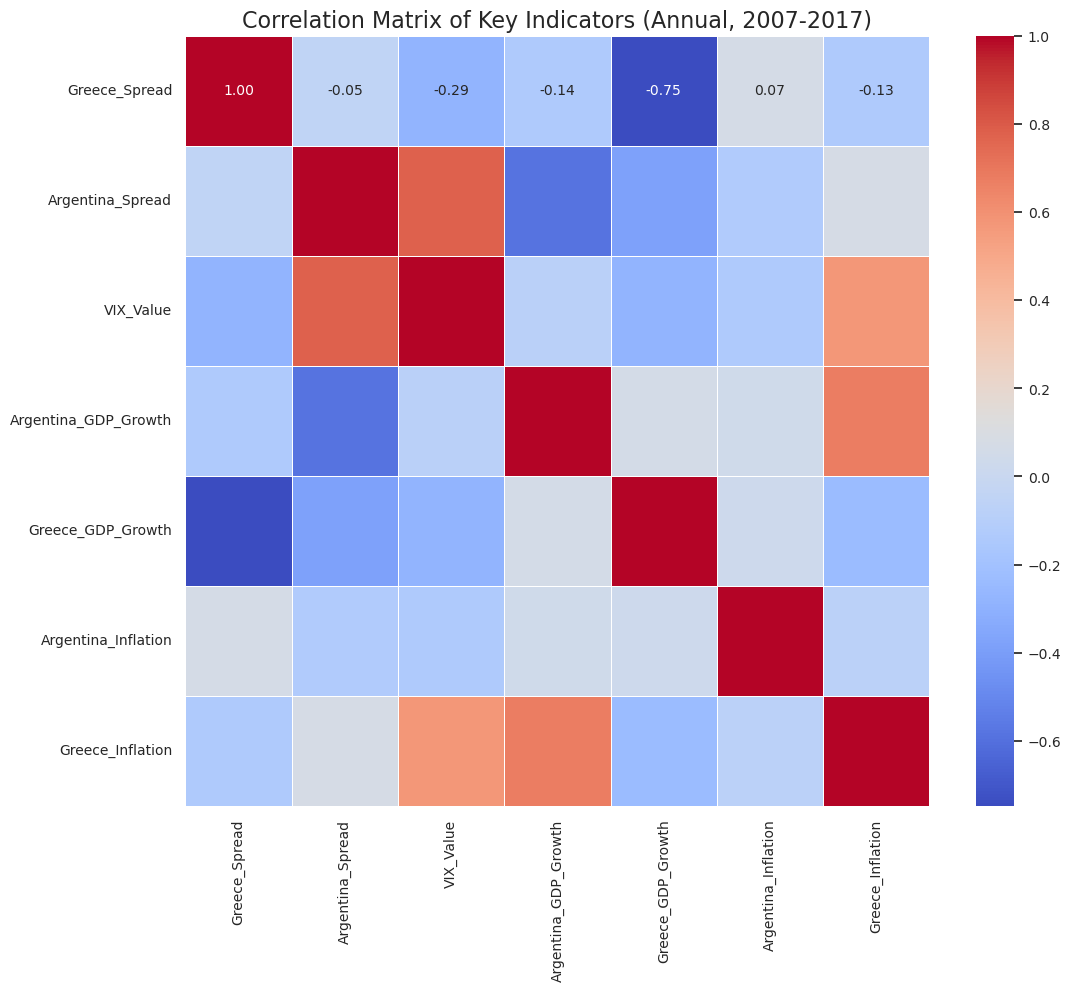

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
US_TREASURY_YIELD_FILE = "US Treasury Bond.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"
ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
GREECE_REAL_GDP_FILE = "Greece_Real_GDP_Annual_Corrected.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv"
GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

START_DATE = '2007-01-01'
END_DATE = '2018-01-01'

def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date, frequency='M', skip_rows=0):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        if 'observation_date' not in df_raw.columns or value_col_name not in df_raw.columns:
            return pd.DataFrame()
        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data['Value'] = pd.to_numeric(df_data['Value'], errors='coerce')
        df_data.dropna(subset=['Value'], inplace=True)
        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()
        if frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
        else:
            df_processed = df_data['Value'].resample('M').mean().to_frame()
        return df_processed
    except FileNotFoundError:
        return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date, skip_rows=0):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        df_filtered = df_raw[
            (df_raw[country_col_name] == target_country) &
            (df_raw[indicator_col_name] == target_indicator_name)
        ].copy()
        if df_filtered.empty:
            return pd.DataFrame()
        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year
        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) < end_year_int]
        if not year_cols:
            return pd.DataFrame()
        df_long = df_filtered.melt(id_vars=[country_col_name, indicator_col_name], value_vars=year_cols, var_name='Year', value_name='Value')
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        df_long.set_index('Year', inplace=True)
        return df_long[['Value']]
    except FileNotFoundError:
        return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, 'IRLTLT01GRM156N', START_DATE, END_DATE, frequency='M')
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, 'IRLTLT01DEM156N', START_DATE, END_DATE, frequency='M')
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, 'BAMLEMRLCRPILAOAS', START_DATE, END_DATE, frequency='M')
df_vix_monthly = load_and_process_fred_csv(VIX_FILE, 'VIXCLS', START_DATE, END_DATE, frequency='M')
df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, 'RGDPNAARA666NRUG', START_DATE, END_DATE, frequency='A')
df_greece_gdp = load_and_process_wide_fred_csv(GREECE_REAL_GDP_FILE, 'COUNTRY', 'INDICATOR', 'Greece', 'Gross domestic product (GDP), Constant prices, Percent change', START_DATE, END_DATE)
df_argentina_cpi = load_and_process_wide_fred_csv(ARGENTINA_CPI_FILE, 'REF_AREA_NAME', 'INDICATOR_NAME', 'Argentina', 'Inflation, annual % change', START_DATE, END_DATE)
df_greece_cpi = load_and_process_fred_csv(GREECE_CPI_FILE, 'FPCPITOTLZGGRC', START_DATE, END_DATE, frequency='A')

df_greece_spread_monthly = pd.DataFrame()
if not df_greek_yield.empty and not df_german_yield.empty:
    df_merged_yields = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_greece_spread_monthly['Greece_Spread'] = df_merged_yields['Value_Greece'] - df_merged_yields['Value_Germany']

df_greece_spread_annual = df_greece_spread_monthly.resample('Y').mean()
df_greece_spread_annual.index = df_greece_spread_annual.index.year
df_argentina_oas_annual = df_argentina_oas.resample('Y').mean()
df_argentina_oas_annual.index = df_argentina_oas_annual.index.year
df_vix_annual = df_vix_monthly.resample('Y').mean()
df_vix_annual.index = df_vix_annual.index.year

df_argentina_oas_annual.rename(columns={'Value': 'Argentina_Spread'}, inplace=True)
df_vix_annual.rename(columns={'Value': 'VIX_Value'}, inplace=True)
df_argentina_gdp.rename(columns={'Value': 'Argentina_GDP_Growth'}, inplace=True)
df_greece_gdp.rename(columns={'Value': 'Greece_GDP_Growth'}, inplace=True)
df_argentina_cpi.rename(columns={'Value': 'Argentina_Inflation'}, inplace=True)
df_greece_cpi.rename(columns={'Value': 'Greece_Inflation'}, inplace=True)

df_correlation_data = pd.DataFrame(index=df_vix_annual.index)
df_correlation_data = df_correlation_data.merge(df_greece_spread_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_oas_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_vix_annual, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_gdp, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_greece_gdp, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_argentina_cpi, left_index=True, right_index=True, how='left')
df_correlation_data = df_correlation_data.merge(df_greece_cpi, left_index=True, right_index=True, how='left')

df_correlation_data.dropna(inplace=True)

if df_correlation_data.empty or len(df_correlation_data.columns) < 2:
    print("\nNot enough common data points after merging for correlation analysis.")
else:
    correlation_matrix = df_correlation_data.corr()
    print(correlation_matrix.round(2))
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Key Indicators (Annual, 2007-2017)', fontsize=16)
    plt.show()

--- Descriptive Statistics (Monthly Data, 2007-2017) ---
       Greece_Spread  Argentina_Spread   VIX_Index
count     131.000000        131.000000  131.000000
mean        7.341640          4.635878   19.884656
std         6.061301          1.744833    9.374796
min         0.230952          1.730000   10.130000
25%         2.448024          3.780000   14.020000
50%         6.862222          4.200000   17.310000
75%         9.161749          5.125000   22.530000
max        27.388095         11.020000   62.670000


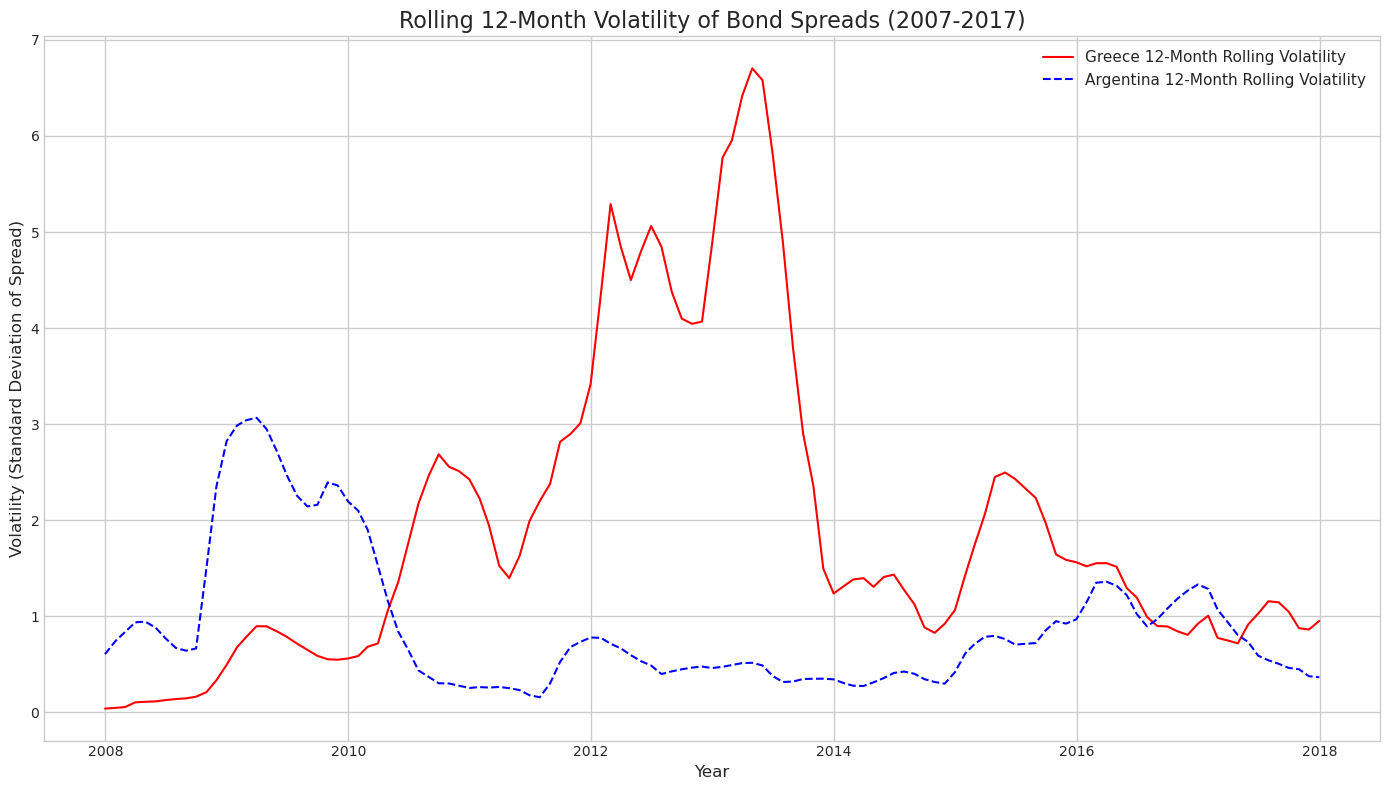

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np

ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"

START_DATE = '2007-01-01'
END_DATE = '2018-01-01'

def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        if 'observation_date' not in df_raw.columns or value_col_name not in df_raw.columns:
            return pd.DataFrame()
        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data['Value'] = pd.to_numeric(df_data['Value'], errors='coerce')
        df_data.dropna(subset=['Value'], inplace=True)
        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()
        return df_data['Value'].resample('M').mean().to_frame()
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, 'IRLTLT01GRM156N', START_DATE, END_DATE)
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, 'IRLTLT01DEM156N', START_DATE, END_DATE)
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, 'BAMLEMRLCRPILAOAS', START_DATE, END_DATE)
df_vix_monthly = load_and_process_fred_csv(VIX_FILE, 'VIXCLS', START_DATE, END_DATE)

df_analysis = pd.DataFrame()
if not df_greek_yield.empty and not df_german_yield.empty:
    df_merged_yields = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_analysis['Greece_Spread'] = df_merged_yields['Value_Greece'] - df_merged_yields['Value_Germany']

if not df_argentina_oas.empty:
    df_analysis = df_analysis.merge(df_argentina_oas.rename(columns={'Value': 'Argentina_Spread'}), left_index=True, right_index=True, how='outer')

if not df_vix_monthly.empty:
    df_analysis = df_analysis.merge(df_vix_monthly.rename(columns={'Value': 'VIX_Index'}), left_index=True, right_index=True, how='outer')

df_analysis.dropna(inplace=True)

print("--- Descriptive Statistics (Monthly Data, 2007-2017) ---")
print(df_analysis.describe())

rolling_window = 12 
df_analysis['Greece_Volatility'] = df_analysis['Greece_Spread'].rolling(window=rolling_window).std()
df_analysis['Argentina_Volatility'] = df_analysis['Argentina_Spread'].rolling(window=rolling_window).std()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(df_analysis.index, df_analysis['Greece_Volatility'], label='Greece 12-Month Rolling Volatility', color='red')
ax.plot(df_analysis.index, df_analysis['Argentina_Volatility'], label='Argentina 12-Month Rolling Volatility', color='blue', linestyle='--')

ax.set_title('Rolling 12-Month Volatility of Bond Spreads (2007-2017)', fontsize=16)
ax.set_xlabel('Year')
ax.set_ylabel('Volatility (Standard Deviation of Spread)')
ax.legend()
plt.tight_layout()
plt.show()


In [20]:
# --- Crisis Period Comparison ---

gfc_period = (df_analysis.index >= '2008-09-01') & (df_analysis.index <= '2009-06-01')
euro_crisis_period = (df_analysis.index >= '2010-01-01') & (df_analysis.index <= '2012-12-31')

print("--- Descriptive Statistics during Global Financial Crisis (Sep 2008 - Jun 2009) ---")
print(df_analysis[gfc_period].describe())
print("\n" + "="*80 + "\n")

print("--- Descriptive Statistics during Eurozone Debt Crisis (2010 - 2012) ---")
print(df_analysis[euro_crisis_period].describe())

--- Descriptive Statistics during Global Financial Crisis (Sep 2008 - Jun 2009) ---
       Greece_Spread  Argentina_Spread  VIX_Index  Greece_Volatility  \
count       9.000000          9.000000   9.000000           9.000000   
mean        1.951782          9.103333  45.732222           0.589132   
std         0.713204          1.836668  11.511478           0.295624   
min         0.785909          5.110000  30.240000           0.163388   
25%         1.533500          8.920000  38.060000           0.334003   
50%         2.032105          9.610000  44.800000           0.677147   
75%         2.529048          9.860000  52.410000           0.843715   
max         2.850455         11.020000  62.670000           0.897355   

       Argentina_Volatility  
count              9.000000  
mean               2.455339  
std                0.835251  
min                0.665375  
25%                2.348647  
50%                2.824550  
75%                2.985825  
max                3.066660

--- Descriptive Statistics during Global Financial Crisis (Sep 2008 - Jun 2009) ---
       Greece_Spread  Argentina_Spread  VIX_Index
count       9.000000          9.000000   9.000000
mean        1.951782          9.103333  45.732222
std         0.713204          1.836668  11.511478
min         0.785909          5.110000  30.240000
25%         1.533500          8.920000  38.060000
50%         2.032105          9.610000  44.800000
75%         2.529048          9.860000  52.410000
max         2.850455         11.020000  62.670000


--- Descriptive Statistics during Eurozone Debt Crisis (2010 - 2012) ---
       Greece_Spread  Argentina_Spread  VIX_Index
count      36.000000         36.000000  36.000000
mean       13.496584          4.324722  21.474444
std         7.066749          0.567292   5.906517
min         2.762500          3.580000  15.280000
25%         8.312750          3.912500  17.395000
50%        13.142641          4.195000  19.665000
75%        17.725254          4.727500  2

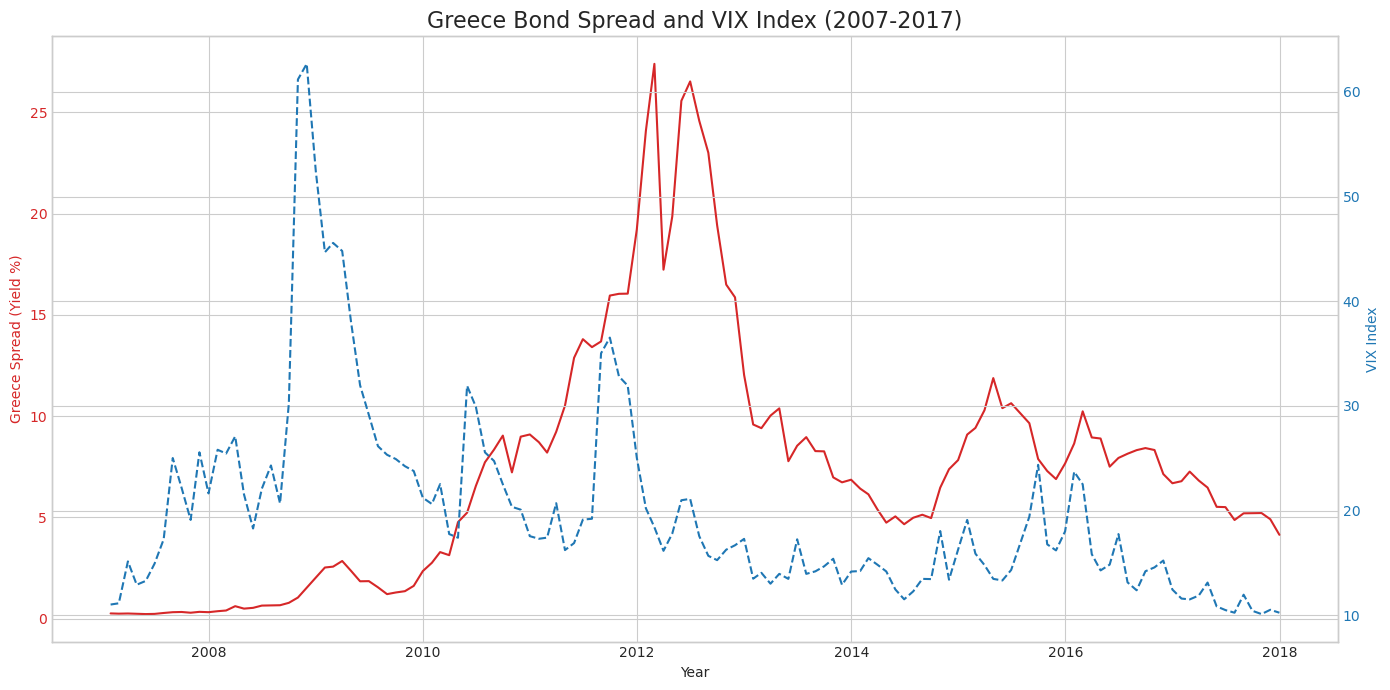

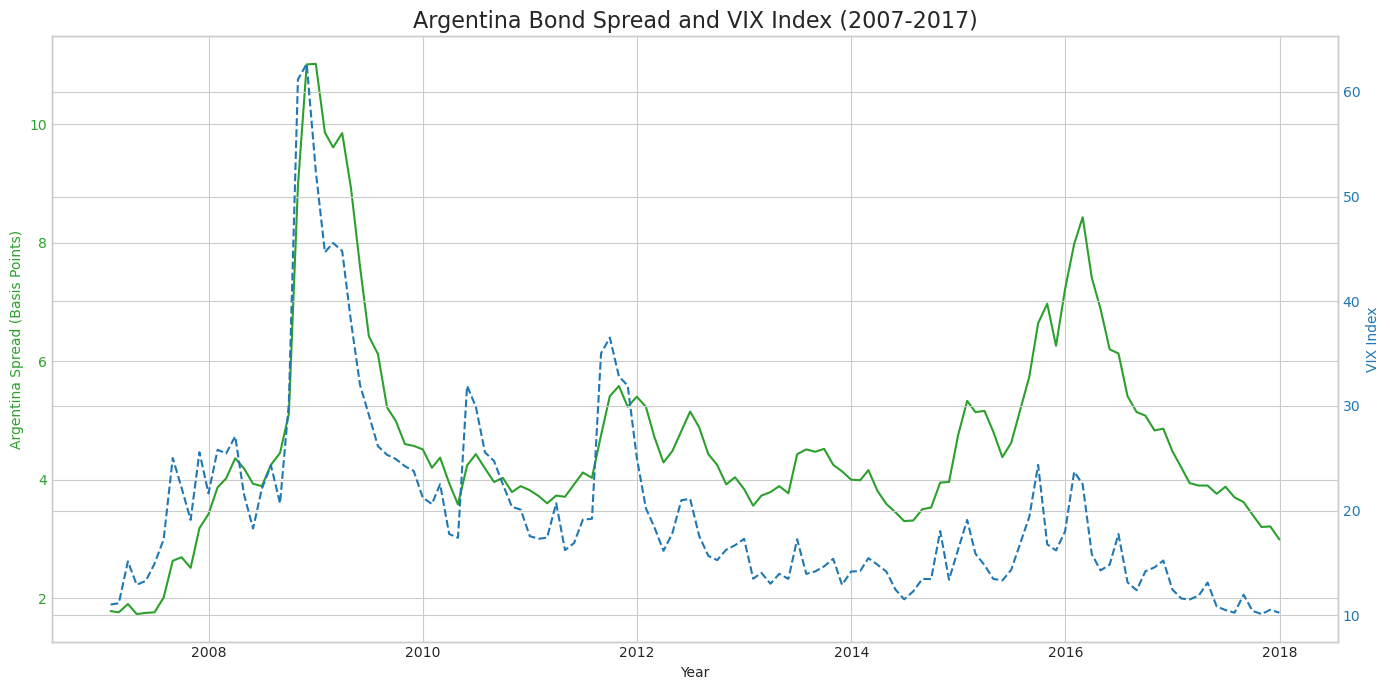

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import statsmodels.api as sm

#--- Configuration and File Paths ---
ARGENTINA_OAS_FILE = "Argentina_LATAM_EM_OAS.csv"
GERMAN_YIELD_FILE = "German bond yield.csv"
GREEK_YIELD_FILE = "Greek 10 year bond yield data alongwith benchmark.csv"
VIX_FILE = "VIXCLS data 2007 to 2018.csv"

#--- Common Time Period for Analysis ---
START_DATE = '2007-01-01'
END_DATE = '2018-01-01'

#--- Data Loading and Processing Function ---
def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        if 'observation_date' not in df_raw.columns or value_col_name not in df_raw.columns:
            return pd.DataFrame()
        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data['Value'] = pd.to_numeric(df_data['Value'], errors='coerce')
        df_data.dropna(subset=['Value'], inplace=True)
        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()
        return df_data['Value'].resample('M').mean().to_frame()
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

#--- Load All Monthly Data ---
df_greek_yield = load_and_process_fred_csv(GREEK_YIELD_FILE, 'IRLTLT01GRM156N', START_DATE, END_DATE)
df_german_yield = load_and_process_fred_csv(GERMAN_YIELD_FILE, 'IRLTLT01DEM156N', START_DATE, END_DATE)
df_argentina_oas = load_and_process_fred_csv(ARGENTINA_OAS_FILE, 'BAMLEMRLCRPILAOAS', START_DATE, END_DATE)
df_vix_monthly = load_and_process_fred_csv(VIX_FILE, 'VIXCLS', START_DATE, END_DATE)

#--- Prepare Analysis DataFrame ---
df_analysis = pd.DataFrame()
if not df_greek_yield.empty and not df_german_yield.empty:
    df_merged_yields = pd.merge(df_greek_yield, df_german_yield, left_index=True, right_index=True, how='inner', suffixes=('_Greece', '_Germany'))
    df_analysis['Greece_Spread'] = df_merged_yields['Value_Greece'] - df_merged_yields['Value_Germany']

if not df_argentina_oas.empty:
    df_analysis = df_analysis.merge(df_argentina_oas.rename(columns={'Value': 'Argentina_Spread'}), left_index=True, right_index=True, how='outer')

if not df_vix_monthly.empty:
    df_analysis = df_analysis.merge(df_vix_monthly.rename(columns={'Value': 'VIX_Index'}), left_index=True, right_index=True, how='outer')

df_analysis.dropna(inplace=True)

#--- 1. Crisis Period Comparison ---
gfc_period = (df_analysis.index >= '2008-09-01') & (df_analysis.index <= '2009-06-01')
euro_crisis_period = (df_analysis.index >= '2010-01-01') & (df_analysis.index <= '2012-12-31')

print("--- Descriptive Statistics during Global Financial Crisis (Sep 2008 - Jun 2009) ---")
print(df_analysis[gfc_period].describe())
print("\n" + "="*80 + "\n")

print("--- Descriptive Statistics during Eurozone Debt Crisis (2010 - 2012) ---")
print(df_analysis[euro_crisis_period].describe())
print("\n" + "="*80 + "\n")

#--- 2. Regression Analysis (Spread vs. VIX) ---
reg_data = df_analysis[['Greece_Spread', 'Argentina_Spread', 'VIX_Index']].dropna()

print("--- OLS Regression Results: Greece Spread vs. VIX Index ---")
y_greece = reg_data['Greece_Spread']
X_greece = sm.add_constant(reg_data['VIX_Index'])
model_greece = sm.OLS(y_greece, X_greece).fit()
print(model_greece.summary())
print("\n" + "="*80 + "\n")

print("--- OLS Regression Results: Argentina Spread vs. VIX Index ---")
y_argentina = reg_data['Argentina_Spread']
X_argentina = sm.add_constant(reg_data['VIX_Index'])
model_argentina = sm.OLS(y_argentina, X_argentina).fit()
print(model_argentina.summary())
print("\n" + "="*80 + "\n")

#--- 3. Visual Overlay with VIX ---
plt.style.use('seaborn-v0_8-whitegrid')

# Plot 1: Greece Spread vs. VIX
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Greece Spread (Yield %)', color=color)
ax1.plot(df_analysis.index, df_analysis['Greece_Spread'], color=color, label='Greece Spread')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('VIX Index', color=color)
ax2.plot(df_analysis.index, df_analysis['VIX_Index'], color=color, linestyle='--', label='VIX Index')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Greece Bond Spread and VIX Index (2007-2017)', fontsize=16)
fig.tight_layout()
plt.show()

# Plot 2: Argentina Spread vs. VIX
fig, ax1 = plt.subplots(figsize=(14, 7))
color = 'tab:green'
ax1.set_xlabel('Year')
ax1.set_ylabel('Argentina Spread (Basis Points)', color=color)
ax1.plot(df_analysis.index, df_analysis['Argentina_Spread'], color=color, label='Argentina Spread')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('VIX Index', color=color)
ax2.plot(df_analysis.index, df_analysis['VIX_Index'], color=color, linestyle='--', label='VIX Index')
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Argentina Bond Spread and VIX Index (2007-2017)', fontsize=16)
fig.tight_layout()
plt.show()

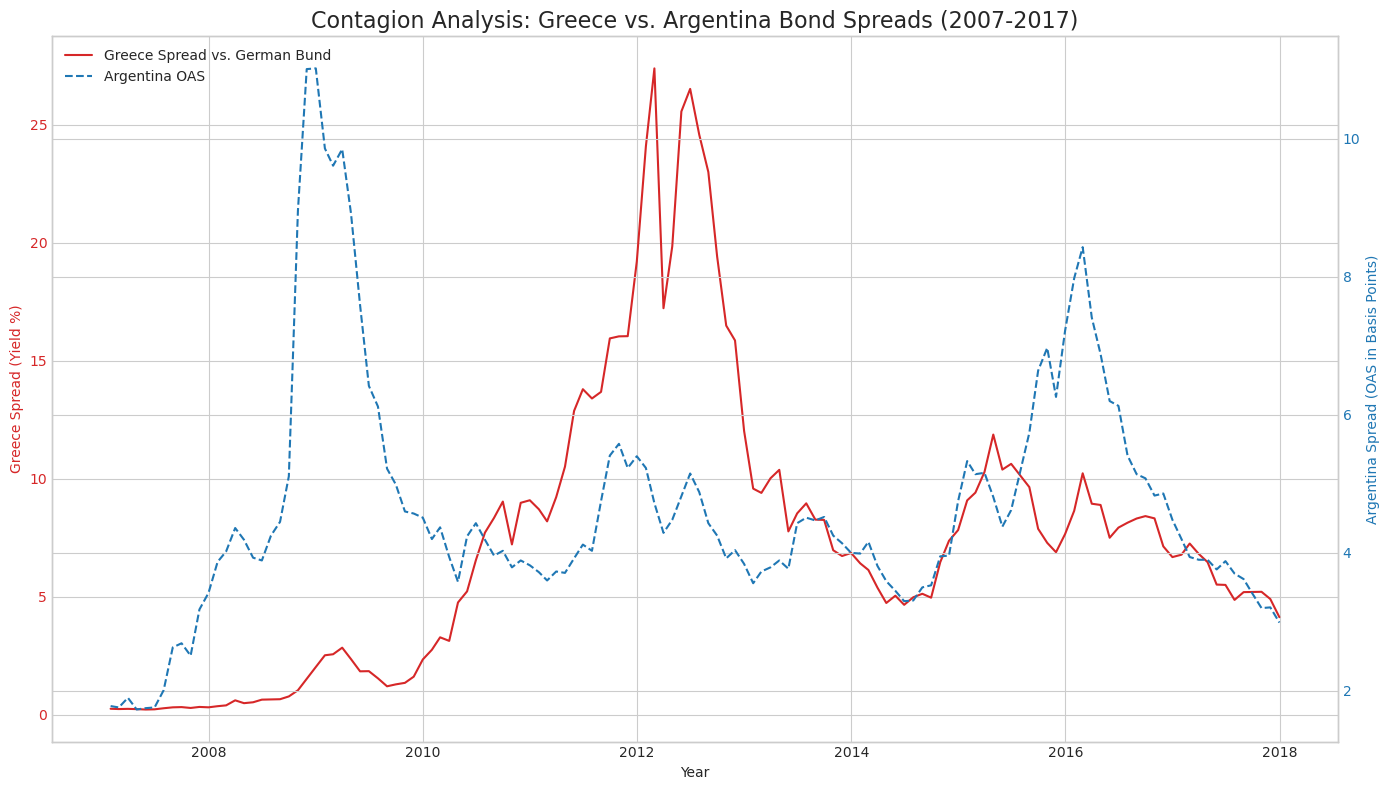

In [2]:
# --- Comparative Plot: Greece Spread vs. Argentina Spread ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot Greece Spread on the primary y-axis (left)
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Greece Spread (Yield %)', color=color)
ax1.plot(df_analysis.index, df_analysis['Greece_Spread'], color=color, label='Greece Spread vs. German Bund')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot Argentina Spread on the secondary y-axis (right)
color = 'tab:blue'
ax2.set_ylabel('Argentina Spread (OAS in Basis Points)', color=color)
ax2.plot(df_analysis.index, df_analysis['Argentina_Spread'], color=color, linestyle='--', label='Argentina OAS')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and a unified legend
plt.title('Contagion Analysis: Greece vs. Argentina Bond Spreads (2007-2017)', fontsize=16)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

fig.tight_layout()
plt.show()

--- OLS Regression Results: Greece GDP Growth vs. Unemployment ---
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     4.473
Date:                Wed, 16 Jul 2025   Prob (F-statistic):             0.0397
Time:                        10:25:36   Log-Likelihood:                -133.82
No. Observations:                  50   AIC:                             271.6
Df Residuals:                      48   BIC:                             275.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

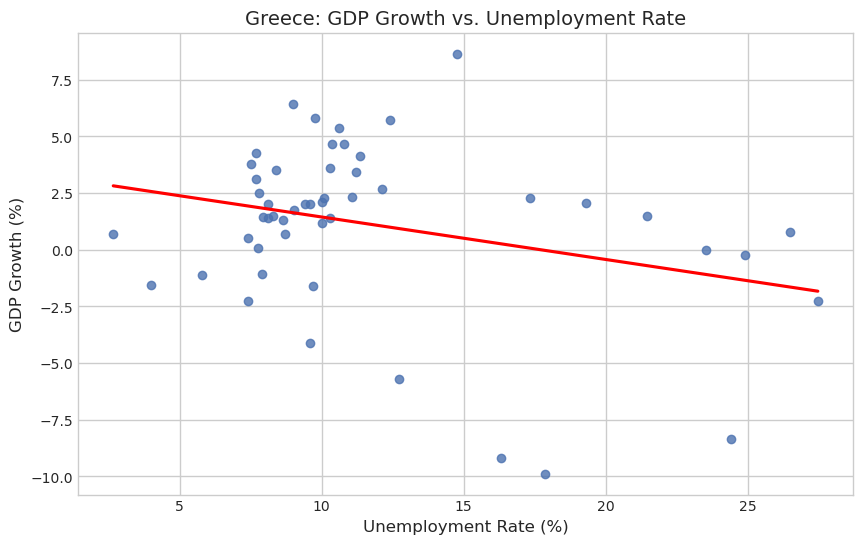

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import statsmodels.api as sm

IMF_WEO_FILE = "debt to gdp greece &argentina_2025-06-06T13_54_16.982603818Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv"
SKIP_ROWS_IMF_WEO = 0

def load_and_process_imf_weo(file_path, skip_rows):
    try:
        df_raw = pd.read_csv(file_path, skiprows=skip_rows)
        if 'COUNTRY' in df_raw.columns:
            df_raw.rename(columns={'COUNTRY': 'Country'}, inplace=True)
        elif 'Country' not in df_raw.columns:
            return pd.DataFrame()
        if 'INDICATOR' not in df_raw.columns:
            if 'Subject Descriptor' in df_raw.columns:
                df_raw.rename(columns={'Subject Descriptor': 'INDICATOR'}, inplace=True)
            elif 'Series Name' in df_raw.columns:
                df_raw.rename(columns={'Series Name': 'INDICATOR'}, inplace=True)
            else:
                return pd.DataFrame()

        indicator_names = {
            'Debt_to_GDP': 'Gross debt, General government, Percent of GDP',
            'GDP_Growth': 'Gross domestic product (GDP), Constant prices, Percent change',
            'Unemployment': 'Unemployment rate',
            'Inflation_CPI': 'All items, Consumer price index (CPI), Period average, percent change'
        }
        df_filtered = df_raw[
            (df_raw['Country'].isin(['Argentina', 'Greece'])) &
            (df_raw['INDICATOR'].isin(indicator_names.values()))
        ].copy()
        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= 1980 and int(col) <= 2030]
        df_selected = df_filtered[['Country', 'INDICATOR'] + year_cols]
        df_long = df_selected.melt(
            id_vars=['Country', 'INDICATOR'],
            value_vars=year_cols,
            var_name='Year',
            value_name='Value'
        )
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        reverse_indicator_map = {v: k for k, v in indicator_names.items()}
        df_long['Indicator_Type'] = df_long['INDICATOR'].map(reverse_indicator_map)
        return df_long
    except FileNotFoundError:
        return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

df_imf_weo = load_and_process_imf_weo(IMF_WEO_FILE, SKIP_ROWS_IMF_WEO)

if df_imf_weo.empty:
    print("No data loaded from IMF WEO file. Cannot perform analysis.")
else:
    df_gdp_growth = df_imf_weo[df_imf_weo['Indicator_Type'] == 'GDP_Growth']
    df_unemployment = df_imf_weo[df_imf_weo['Indicator_Type'] == 'Unemployment']

    greece_gdp = df_gdp_growth[df_gdp_growth['Country'] == 'Greece'][['Year', 'Value']].rename(columns={'Value': 'GDP_Growth'})
    greece_unemployment = df_unemployment[df_unemployment['Country'] == 'Greece'][['Year', 'Value']].rename(columns={'Value': 'Unemployment_Rate'})
    greece_analysis_df = pd.merge(greece_gdp, greece_unemployment, on='Year')

    if not greece_analysis_df.empty and len(greece_analysis_df) > 1:
        y = greece_analysis_df['GDP_Growth']
        X = sm.add_constant(greece_analysis_df['Unemployment_Rate'])
        model = sm.OLS(y, X).fit()

        print("--- OLS Regression Results: Greece GDP Growth vs. Unemployment ---")
        print(model.summary())

        plt.figure(figsize=(10, 6))
        sns.regplot(x='Unemployment_Rate', y='GDP_Growth', data=greece_analysis_df, ci=None, line_kws={'color': 'red'})
        plt.title('Greece: GDP Growth vs. Unemployment Rate')
        plt.xlabel('Unemployment Rate (%)')
        plt.ylabel('GDP Growth (%)')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough data to perform regression for Greece.")


--- OLS Regression Results: Argentina GDP Growth vs. Inflation ---
                             OLS Regression Results                             
Dep. Variable:     Argentina_GDP_Growth   R-squared:                       0.001
Model:                              OLS   Adj. R-squared:                 -0.061
Method:                   Least Squares   F-statistic:                   0.02379
Date:                  Wed, 16 Jul 2025   Prob (F-statistic):              0.879
Time:                          10:25:47   Log-Likelihood:                -54.378
No. Observations:                    18   AIC:                             112.8
Df Residuals:                        16   BIC:                             114.5
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  k, _ = kurtosistest(a, axis)


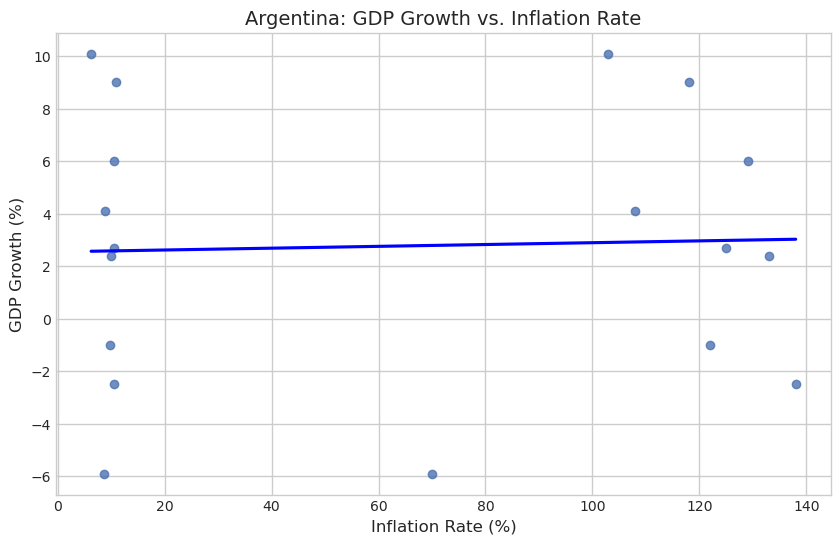

In [22]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ARGENTINA_REAL_GDP_FILE = "Argentina_Real_GDP_Annual.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv"
START_DATE = '2007-01-01'
END_DATE = '2018-01-01'

def load_and_process_fred_csv(file_path, value_col_name, start_date, end_date, frequency='A'):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        if 'observation_date' not in df_raw.columns or value_col_name not in df_raw.columns:
            return pd.DataFrame()
        df_data = df_raw.rename(columns={'observation_date': 'Date', value_col_name: 'Value'})
        df_data['Date'] = pd.to_datetime(df_data['Date'], errors='coerce')
        df_data.set_index('Date', inplace=True)
        df_data['Value'] = pd.to_numeric(df_data['Value'], errors='coerce')
        df_data.dropna(subset=['Value'], inplace=True)
        df_data = df_data[(df_data.index >= start_date) & (df_data.index < end_date)].copy()
        if frequency == 'A':
            df_processed = df_data['Value'].resample('Y').mean().to_frame()
            df_processed['Year'] = df_processed.index.year
            df_processed.set_index('Year', inplace=True)
            return df_processed
        else:
            return df_data['Value'].to_frame()
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

def load_and_process_wide_fred_csv(file_path, country_col_name, indicator_col_name, target_country, target_indicator_name, start_date, end_date):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        df_filtered = df_raw[(df_raw[country_col_name] == target_country) & (df_raw[indicator_col_name] == target_indicator_name)].copy()
        if df_filtered.empty:
            return pd.DataFrame()
        start_year_int = pd.to_datetime(start_date).year
        end_year_int = pd.to_datetime(end_date).year
        year_cols = [col for col in df_filtered.columns if str(col).isdigit() and int(col) >= start_year_int and int(col) < end_year_int]
        if not year_cols:
            return pd.DataFrame()
        df_long = df_filtered.melt(id_vars=[country_col_name, indicator_col_name], value_vars=year_cols, var_name='Year', value_name='Value')
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        df_long.set_index('Year', inplace=True)
        return df_long[['Value']]
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

df_argentina_gdp = load_and_process_fred_csv(ARGENTINA_REAL_GDP_FILE, 'RGDPNAARA666NRUG', START_DATE, END_DATE, frequency='A')
df_argentina_cpi = load_and_process_wide_fred_csv(ARGENTINA_CPI_FILE, 'REF_AREA_NAME', 'INDICATOR_NAME', 'Argentina', 'Inflation, annual % change', START_DATE, END_DATE)

if df_argentina_gdp.empty or df_argentina_cpi.empty:
    print("Could not load data for Argentina. Please check file paths and ensure the files exist.")
else:
    argentina_analysis_df = pd.merge(df_argentina_gdp, df_argentina_cpi, left_index=True, right_index=True)
    argentina_analysis_df.rename(columns={'Value_x': 'Argentina_GDP_Growth', 'Value_y': 'Argentina_Inflation'}, inplace=True)
    argentina_analysis_df.dropna(inplace=True)

    if not argentina_analysis_df.empty and len(argentina_analysis_df) > 1:
        y = argentina_analysis_df['Argentina_GDP_Growth']
        X = sm.add_constant(argentina_analysis_df['Argentina_Inflation'])
        model = sm.OLS(y, X).fit()
        print("\n--- OLS Regression Results: Argentina GDP Growth vs. Inflation ---")
        print(model.summary())
        plt.figure(figsize=(10, 6))
        sns.regplot(x='Argentina_Inflation', y='Argentina_GDP_Growth', data=argentina_analysis_df, ci=None, line_kws={'color': 'blue'})
        plt.title('Argentina: GDP Growth vs. Inflation Rate')
        plt.xlabel('Inflation Rate (%)')
        plt.ylabel('GDP Growth (%)')
        plt.grid(True)
        plt.show()
    else:
        print("Not enough common data to perform regression for Argentina.")

In [23]:
import pandas as pd

GREECE_CPI_FILE = "Greece CPI Inflation 2007 to 2018.csv"

try:
    df_test_greece = pd.read_csv(GREECE_CPI_FILE)
    print("--- Successfully read the Greek CPI file. ---")
    print("\n--- First 5 Rows ---")
    print(df_test_greece.head())
    print("\n--- Detected Column Names ---")
    print(df_test_greece.columns.tolist())

except FileNotFoundError:
    print("--- ERROR: File Not Found ---")
    print(f"The file '{GREECE_CPI_FILE}' was not found in the directory.")
    print("Please ensure it has been uploaded and the name is spelled correctly.")
except Exception as e:
    print(f"An error occurred while trying to read the file: {e}")

--- Successfully read the Greek CPI file. ---

--- First 5 Rows ---
  observation_date  FPCPITOTLZGGRC
0       2007-01-01        2.895003
1       2008-01-01        4.152797
2       2009-01-01        1.210073
3       2010-01-01        4.712989
4       2011-01-01        3.329853

--- Detected Column Names ---
['observation_date', 'FPCPITOTLZGGRC']


In [24]:
import pandas as pd

GREECE_CPI_FILE_NEW = "Greece CPI Inflation.csv"

try:
    df_test_greece_new = pd.read_csv(GREECE_CPI_FILE_NEW)
    print("--- Successfully read the NEW Greek CPI file. ---")
    print("\n--- First 5 Rows ---")
    print(df_test_greece_new.head())
    print("\n--- Detected Column Names ---")
    print(df_test_greece_new.columns.tolist())

except FileNotFoundError:
    print("--- ERROR: File Not Found ---")
    print(f"The file '{GREECE_CPI_FILE_NEW}' was not found in the directory.")
    print("Please ensure it has been uploaded and the name is spelled correctly.")
except Exception as e:
    print(f"An error occurred while trying to read the file: {e}")

--- Successfully read the NEW Greek CPI file. ---

--- First 5 Rows ---
              DATASET    SERIES_CODE OBS_MEASURE COUNTRY  \
0  IMF.RES:WEO(6.0.0)  GRC.PCPIPCH.A   OBS_VALUE  Greece   

                                           INDICATOR FREQUENCY  SCALE   2000  \
0  All Items, Consumer price index (CPI), Period ...    Annual  Units  2.897   

    2001   2002  ...   2015   2016   2017   2018   2019   2020   2021  2022  \
0  3.642  3.921  ... -1.094  0.013  1.138  0.774  0.517 -1.262  0.574   9.3   

    2023   2024  
0  4.155  2.997  

[1 rows x 32 columns]

--- Detected Column Names ---
['DATASET', 'SERIES_CODE', 'OBS_MEASURE', 'COUNTRY', 'INDICATOR', 'FREQUENCY', 'SCALE', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [44]:
import pandas as pd

GREECE_CPI_FILE = "Greece CPI Inflation.csv"

print(f"--- Starting Final Diagnostic for: {GREECE_CPI_FILE} ---")

try:
    df_test = pd.read_csv(GREECE_CPI_FILE)
    print("\nFile was read successfully.")
    
    print("\n--- DataFrame Info ---")
    df_test.info()
    
    print("\n--- First 5 Rows ---")
    print(df_test.head())

except FileNotFoundError:
    print(f"\n--- FATAL ERROR: The file '{GREECE_CPI_FILE}' could not be found.")
    print("Please ensure the file is uploaded and the name matches exactly.")
except Exception as e:
    print(f"\n--- An unexpected error occurred: {e}")

--- Starting Final Diagnostic for: Greece CPI Inflation.csv ---

File was read successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATASET      1 non-null      object 
 1   SERIES_CODE  1 non-null      object 
 2   OBS_MEASURE  1 non-null      object 
 3   COUNTRY      1 non-null      object 
 4   INDICATOR    1 non-null      object 
 5   FREQUENCY    1 non-null      object 
 6   SCALE        1 non-null      object 
 7   2000         1 non-null      float64
 8   2001         1 non-null      float64
 9   2002         1 non-null      float64
 10  2003         1 non-null      float64
 11  2004         1 non-null      float64
 12  2005         1 non-null      float64
 13  2006         1 non-null      float64
 14  2007         1 non-null      float64
 15  2008         1 non-null      float64
 16  2009         1 non-nu

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

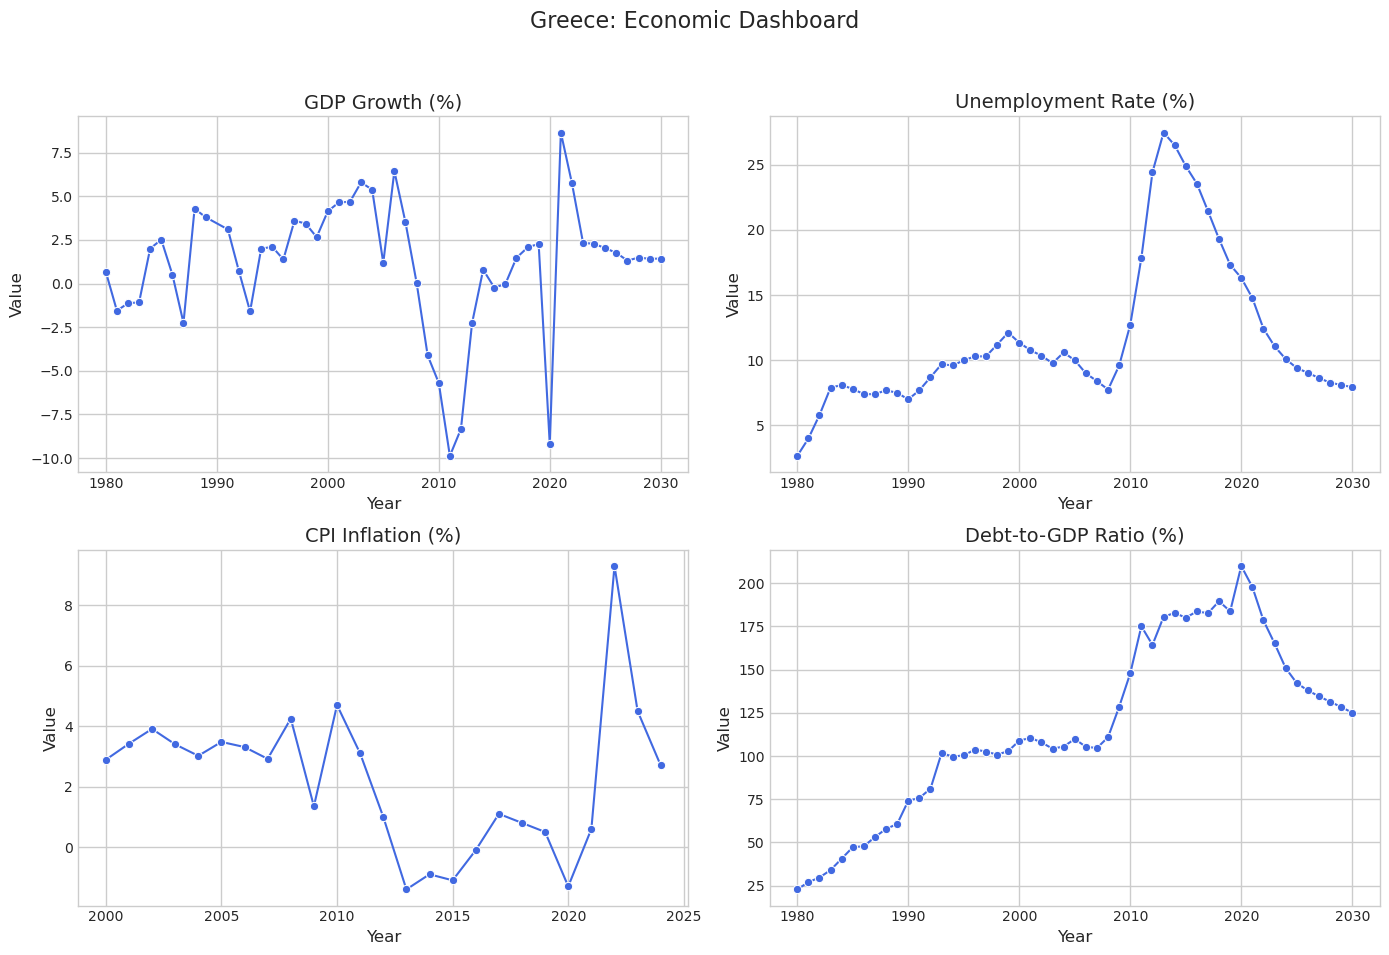

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

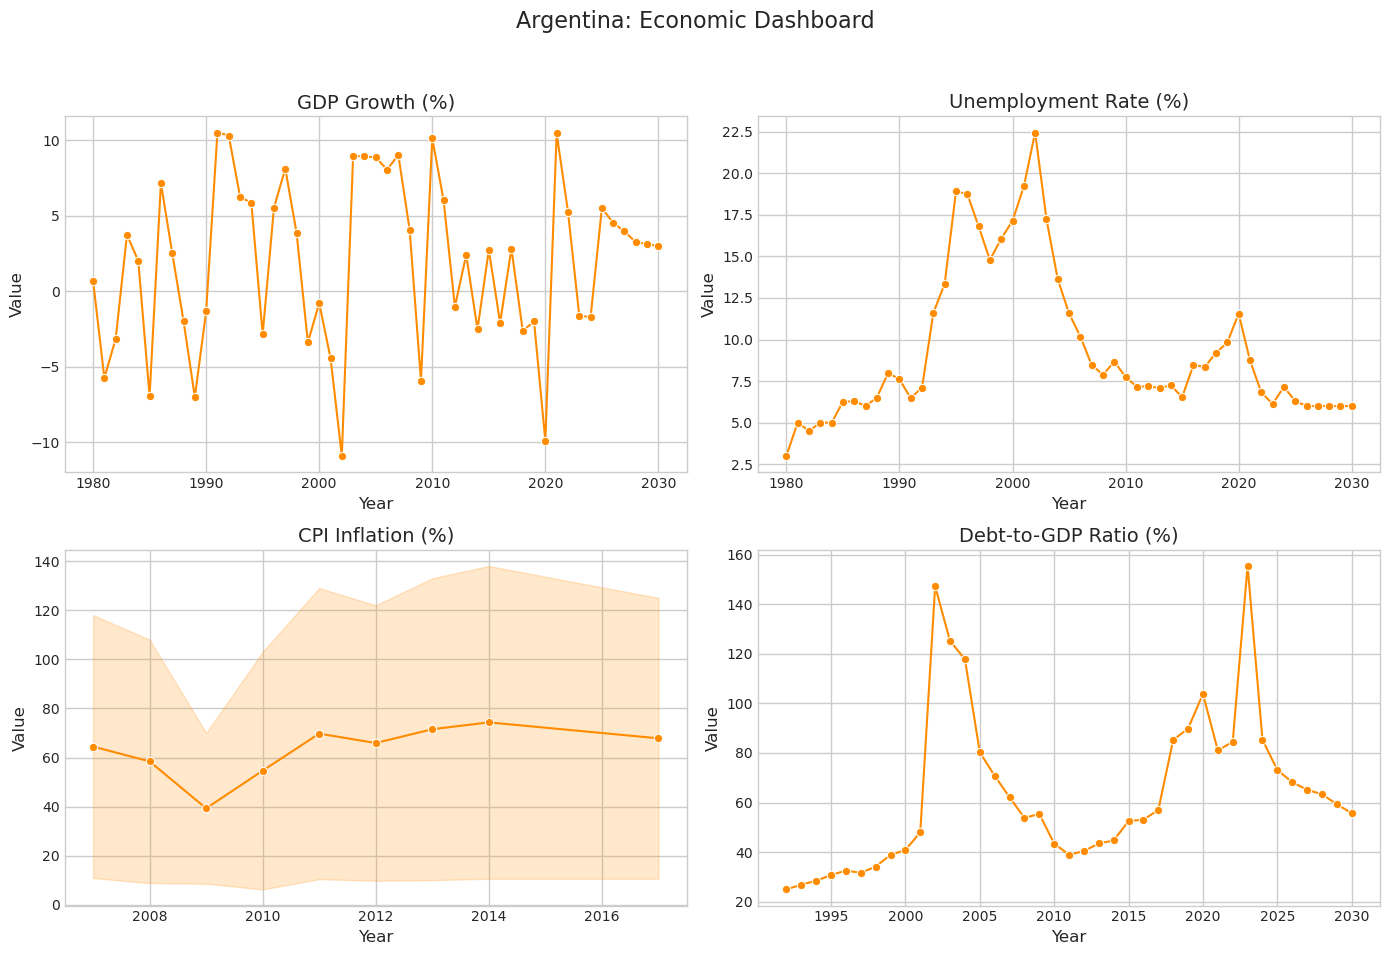

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

IMF_WEO_FILE = "debt to gdp greece &argentina_2025-06-06T13_54_16.982603818Z_DEFAULT_INTEGRATION_IMF.RES_WEO_6.0.0.csv"
ARGENTINA_CPI_FILE = "Inflation data for argentina %change.csv"

greece_cpi_data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Value': [2.89, 3.42, 3.91, 3.40, 3.02, 3.48, 3.31, 2.92, 4.25, 1.35, 4.70, 3.10, 1.00, -1.40, -0.90, -1.10, -0.10, 1.10, 0.80, 0.50, -1.30, 0.60, 9.30, 4.50, 2.70]
}
df_greece_cpi = pd.DataFrame(greece_cpi_data)

def load_and_process_imf_weo(file_path):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0)
        df_raw.rename(columns={'COUNTRY': 'Country', 'INDICATOR': 'INDICATOR'}, inplace=True)
        indicator_names = {
            'Debt_to_GDP': 'Gross debt, General government, Percent of GDP',
            'GDP_Growth': 'Gross domestic product (GDP), Constant prices, Percent change',
            'Unemployment': 'Unemployment rate'
        }
        df_filtered = df_raw[df_raw['INDICATOR'].isin(indicator_names.values())].copy()
        year_cols = [col for col in df_filtered.columns if str(col).isdigit()]
        df_long = df_filtered.melt(id_vars=['Country', 'INDICATOR'], value_vars=year_cols, var_name='Year', value_name='Value')
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        df_long.dropna(subset=['Value', 'Year'], inplace=True)
        reverse_indicator_map = {v: k for k, v in indicator_names.items()}
        df_long['Indicator_Type'] = df_long['INDICATOR'].map(reverse_indicator_map)
        return df_long[df_long['Country'].isin(['Argentina', 'Greece'])]
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

def load_argentina_cpi(file_path):
    try:
        df_raw = pd.read_csv(file_path, skiprows=0, engine='python')
        df_raw.columns = [col.strip().strip("\"") for col in df_raw.columns]
        df_filtered = df_raw[(df_raw['REF_AREA_NAME'] == 'Argentina') & (df_raw['INDICATOR_NAME'] == 'Inflation, annual % change')].copy()
        year_cols = [col for col in df_filtered.columns if str(col).isdigit()]
        df_long = df_filtered.melt(id_vars=['REF_AREA_NAME', 'INDICATOR_NAME'], value_vars=year_cols, var_name='Year', value_name='Value')
        df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce').astype(int)
        df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
        return df_long[['Year', 'Value']].dropna()
    except (FileNotFoundError, Exception):
        return pd.DataFrame()

df_imf_weo = load_and_process_imf_weo(IMF_WEO_FILE)
df_argentina_cpi = load_argentina_cpi(ARGENTINA_CPI_FILE)

inflation_indicator_name = 'All items, Consumer price index (CPI), Period average, percent change'
if not df_greece_cpi.empty:
    df_greece_cpi['Country'] = 'Greece'
    df_greece_cpi['Indicator_Type'] = 'Inflation_CPI'
    df_greece_cpi['INDICATOR'] = inflation_indicator_name
    df_imf_weo = pd.concat([df_imf_weo, df_greece_cpi], ignore_index=True)

if not df_argentina_cpi.empty:
    df_argentina_cpi['Country'] = 'Argentina'
    df_argentina_cpi['Indicator_Type'] = 'Inflation_CPI'
    df_argentina_cpi['INDICATOR'] = inflation_indicator_name
    df_imf_weo = pd.concat([df_imf_weo, df_argentina_cpi], ignore_index=True)

indicators_to_plot = {
    'GDP_Growth': 'GDP Growth (%)',
    'Unemployment': 'Unemployment Rate (%)',
    'Inflation_CPI': 'CPI Inflation (%)',
    'Debt_to_GDP': 'Debt-to-GDP Ratio (%)'
}

for country_name in ['Greece', 'Argentina']:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{country_name}: Economic Dashboard', fontsize=16)
    axes = axes.flatten()
    for i, (indicator_code, indicator_name) in enumerate(indicators_to_plot.items()):
        ax = axes[i]
        plot_data = df_imf_weo[(df_imf_weo['Country'] == country_name) & (df_imf_weo['Indicator_Type'] == indicator_code)]
        if not plot_data.empty:
            sns.lineplot(x='Year', y='Value', data=plot_data, ax=ax, marker='o', color='darkorange' if country_name == 'Argentina' else 'royalblue')
        ax.set_title(indicator_name)
        ax.set_xlabel('Year')
        ax.set_ylabel('Value')
        ax.grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [26]:
import pandas as pd
import statsmodels.api as sm

contagion_data = df_analysis[['Argentina_Spread', 'Greece_Spread', 'VIX_Index']].dropna()

if len(contagion_data) > 2:
    y = contagion_data['Argentina_Spread']
    X = contagion_data[['Greece_Spread', 'VIX_Index']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    print("--- Contagion Analysis: Argentina Spread vs. Greece Spread & VIX ---")
    print(model.summary())
else:
    print("Not enough overlapping data to perform the contagion analysis.")

--- Contagion Analysis: Argentina Spread vs. Greece Spread & VIX ---
                            OLS Regression Results                            
Dep. Variable:       Argentina_Spread   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     72.21
Date:                Wed, 16 Jul 2025   Prob (F-statistic):           1.01e-21
Time:                        11:29:49   Log-Likelihood:                -208.83
No. Observations:                 131   AIC:                             423.7
Df Residuals:                     128   BIC:                             432.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [27]:
import pandas as pd
import statsmodels.api as sm

df_regression = df_imf_weo[
    df_imf_weo['Indicator_Type'].isin(['Debt_to_GDP', 'GDP_Growth'])
].pivot_table(
    index=['Country', 'Year'], 
    columns='Indicator_Type', 
    values='Value'
).reset_index().dropna()

df_regression.rename(columns={
    'Debt_to_GDP': 'Debt_to_GDP_Ratio',
    'GDP_Growth': 'GDP_Growth_Rate'
}, inplace=True)

df_greece_reg = df_regression[df_regression['Country'] == 'Greece'].copy()

if len(df_greece_reg) > 2:
    debt_threshold = 100.0    
    df_greece_reg['debt_over_threshold'] = df_greece_reg['Debt_to_GDP_Ratio'] - debt_threshold
    df_greece_reg['debt_over_threshold'] = df_greece_reg['debt_over_threshold'].clip(lower=0)
    y = df_greece_reg['GDP_Growth_Rate']
    X = df_greece_reg[['Debt_to_GDP_Ratio', 'debt_over_threshold']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()    
    print("\n--- Debt Overhang Threshold Analysis for Greece (Threshold = 100%) ---")
    print(model.summary())
else:
    print("Not enough data for Greece to perform the debt overhang analysis.")


--- Debt Overhang Threshold Analysis for Greece (Threshold = 100%) ---
                            OLS Regression Results                            
Dep. Variable:        GDP_Growth_Rate   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     3.673
Date:                Wed, 16 Jul 2025   Prob (F-statistic):             0.0329
Time:                        11:32:02   Log-Likelihood:                -132.41
No. Observations:                  50   AIC:                             270.8
Df Residuals:                      47   BIC:                             276.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------